In [1]:
# 1. Change Bridge nodes in processing results
# 2. Run bridge algo for multiple parameters and rest can be done only once
# 3. Use Global diversified or Deep diversified in the article.
# 4. Suffle the results for every iteration
# 5.

In [2]:


# %pip install 'networkx<2.7'

In [3]:
# !pip install cdlib

In [4]:
import os
import heapq
import argparse
import threading
import multiprocessing
import sys
import queue


from __future__ import division
import math, time
from copy import deepcopy
import multiprocessing, json
from tqdm import tqdm
import heapq
from heapq import nlargest

import matplotlib.pyplot as plt

from networkx.algorithms import community

import networkx as nx
import community as community_louvain


#importing libraries that will be used
# import networkx as nx#for creating network
# import numpy as np
# import matplotlib.pyplot as plt#for plotting plots
# import random
# import time#claculating time
# import math
# from collections import Counter
# from itertools import permutations
# from itertools import combinations

# from collections import defaultdict
# from scipy.io import mmread# to read dataset
# import pandas as pd



In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !pip uninstall community

In [7]:
# !pip install python-louvain

In [8]:
# pip install networkx

In [9]:
#importing libraries that will be used
import networkx as nx#for creating network
# import community.community_louvain
# import community.community_louvain as community_louvain
from networkx.algorithms import structuralholes
import numpy as np
import matplotlib.pyplot as plt#for plotting plots

import random
import time#claculating time
import math
from collections import Counter
from itertools import permutations
from itertools import combinations

from collections import defaultdict
from scipy.io import mmread# to read dataset
import pandas as pd

# from cdlib import algorithms

In [10]:
def celf(graph, k):
    # Initialize variables
    nodes = []
    heap = []
    marg_gains = {}

    # Calculate the marginal gain for each node
    for node in graph.nodes():
        # Run Monte Carlo simulations to estimate the influence of each node
        sim_res = IC_new(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the heap with its marginal gain as key
        heapq.heappush(heap, (-marg_gains[node], node))

    # Select the k nodes with the highest influence scores
    while len(nodes) < k:
        # Get the node with the highest marginal gain
        _, node = heapq.heappop(heap)
        # Recalculate the marginal gain of the selected node
        sim_res = IC_new(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the list of selected nodes
        nodes.append(node)
        # Update the heap with the new marginal gains
        for n in graph.neighbors(node):
            if n not in nodes:
                heapq.heappush(heap, (-marg_gains[n], n))

    return nodes


In [11]:
# pip install heapdict

In [12]:
# import diffusion
from heapdict import heapdict

class Node(object):
    def __init__(self, node):
        self.node = node
        self.mg1 = 0
        self.prev_best = None
        self.mg2 = 0
        self.flag = None
        self.list_index = 0

def CELFPP_linear_Threshold(graph, s):
    seeds=list()
    for e in s:
        seeds.append(e)
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float)
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return len(influnces)

def celfpp(G, k):
    S = set()
    # Note that heapdict is min heap and hence add negative priorities for
    # it to work.
    Q = heapdict()
    last_seed = None
    cur_best = None
    node_data_list = []

    for node in G.nodes:
        node_data = Node(node)
        node_data.mg1 = CELFPP_linear_Threshold(G,[node])
        node_data.prev_best = cur_best
        node_data.mg2 = CELFPP_linear_Threshold(G,[node, cur_best.node]) if cur_best else node_data.mg1
        node_data.flag = 0
        cur_best = cur_best if cur_best and cur_best.mg1 > node_data.mg1 else node_data
        G.nodes[node]['node_data'] = node_data
        node_data_list.append(node_data)
        node_data.list_index = len(node_data_list) - 1
        Q[int(node_data.list_index)] = - node_data.mg1

    while len(S) < k:
        node_idx, _ = Q.peekitem()
        node_data = node_data_list[node_idx]
        if node_data.flag == len(S):
            S.add(node_data.node)
            del Q[node_idx]
            last_seed = node_data
            continue
        elif node_data.prev_best == last_seed:
            node_data.mg1 = node_data.mg2
        else:
            before = CELFPP_linear_Threshold(G,S)
            S.add(node_data.node)
            after = CELFPP_linear_Threshold(G,S)
            S.remove(node_data.node)
            node_data.mg1 = after - before
            node_data.prev_best = cur_best
            S.add(cur_best.node)
            before = CELFPP_linear_Threshold(G,S)
            S.add(node_data.node)
            after = CELFPP_linear_Threshold(G,S)
            S.remove(cur_best.node)
            if node_data.node != cur_best.node: S.remove(node_data.node)
            node_data.mg2 = after - before

        if cur_best and cur_best.mg1 < node_data.mg1:
            cur_best = node_data

        node_data.flag = len(S)
        Q[node_idx] = - node_data.mg1
    SS=list(S)
#     print("final seed set:",SS)
    return SS

In [13]:
def Greedy(G,k):
    print("in Greedy")
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
    for i in range(k):
        for v in (V-mySet1):
            mySet1.append(v)
            a=linear_Threshold(G,mySet1)
            Dict[v]=len(a)#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)


In [14]:
# ratiolevel0bridge=25
# executeDiv()
# processResults()

In [15]:
# #!/usr/bin/env python
# # coding: utf-8

# # In[2]:


# """
# Model Parameters :
#     GRAPH :
#         directed
#         node :
#             node_id
#             label
#             probability
#         edge :
#             source
#             target

#     n -> population size
#     k -> seed set size
#     flight_length -> flight lengths of crows
#     epoch -> max number of iterations
#     awareness_probability-> awareness probability
#     alpha -> constant to calculate node_contribution_index. used for optimisation using random walk
#     beta ->  constant to select candidates for random walk
# """


# # In[3]:


# import random
# import itertools


# # In[4]:



# #build graph from data
# # G = nx.read_gml("test1.gml", label = 'id')

# #visualizing the graph
# # print(G.nodes(data=True))
# # print(G.edges(data=True))

# # Define node positions (optional)
# # pos = nx.spring_layout(G)
# # Get node labels
# # node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
# # Draw the graph
# # nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')


# # In[ ]:


# # print(G.out_degree())


# # In[5]:


# #replace for diversity in crow nodes
# def replace(j,seed,left):
# #     print("In replace:",j,seed,left)
#     index = random.randint(0,len(left) - 1)
#     seed[j], left[index] = left[index], seed[j]
# #     print("seed[j]",seed[j])
#     return seed[j]


# # returns a list of crow positions
# def initialize_population(G, n, k) :
#     nodes_degree = list(G.out_degree())
#     nodes_degree = [x[0] for x in sorted(nodes_degree, key=lambda x: x[1])]
# #     print("nodes_degree:",nodes_degree)
#     population = []
#     for i in range(n) :
#         seed, left = nodes_degree[:k], nodes_degree[k:]
# #         print(seed,left)
#         for j in range(k):
#             if(random.random() > 0.9):                                                          # REPLACEMENT PARAMETER = 0.5
#                 seed[j] = replace(j,seed,left)
#         population.append(seed)
#     return population


# # In[ ]:


# # initialize_population(G, 1, 5)


# # In[6]:


# #initialize a vector r_val[n] where 0<r[i]<1
# def initialize_random(n):
# #     r_val=dict()
# #     for node in G.nodes():
# #         print(node)
# #         r_val[node]=random.random()
#     r_val = [random.random() for i in range(n)]
#     return r_val


# # In[ ]:


# # initialize_random(3)


# # In[7]:


# # def local_influence_estimate(G : nx.classes.digraph.DiGraph, seed : list) :
# #     k = len(seed)
# #     seed_set = set(seed)


# #     one_neighbours = set()
# #     for node_id in seed_set :
# #         one_neighbours.update(set(G.neighbors(node_id)))
# #     one_neighbours = one_neighbours - seed_set


# #     two_neighbours = set()
# #     for node_id1 in one_neighbours :
# #         two_neighbours.update(set(G.neighbors(node_id1)))
# #     two_neighbours = two_neighbours - seed_set

# #     one_hop_area = len(one_neighbours)
# #     if one_hop_area == 0:
# #         return k
# #     two_hop_area = len(two_neighbours)

# #     sigma_0 = k
# #     sigma_1 = 0
# #     for node_id1 in one_neighbours:
# #         val = 1
# #         for node_id in seed_set:
# # #             print("edge:", node_id,"->",node_id1)
# #             if(G.has_edge(node_id,node_id1)) :
# # #                 print("Yes edge is present:", node_id,"->",node_id1)
# # #                 p = G.nodes[node_id]['probability']

# # #                 for u, v, data in G.edges(data=True):
# # #                     weight = data['weight']
# # #                     print(f"Edge {u}-{v} has weight {weight}")

# #                 p = G[node_id][node_id1]['weight']
# #                 val = val * ( 1 - p)
# #         sigma_1 += (1 - val)

# #     factor = 0


# #     for node_id2 in two_neighbours:
# #         p = G.nodes[node_id2]['probability']
# #         d = 0
# #         for node_id1 in one_neighbours:
# #             if(G.has_edge(node_id2, node_id1)):
# #                 d += 1
# #         factor += p*d

# #     factor /= one_hop_area
# #     factor += 1

# #     LIE = sigma_0 + factor * sigma_1
# #     return LIE





# def local_influence_estimate(graph, seeds):
#     influnces = seeds[:]
#     queue = influnces[:]
#     pre_node_record = defaultdict(float)
# #     print("Queue:",queue)
# #     print("Influences:",influnces)
#     while len(queue) != 0:
#         node = queue.pop(0)
# #         print("----------------------------------------------------------------------")
# #         print("Take node:",node)
# #         print("Neighbour:",graph[node])
#         for element in graph[node]:
#             if element not in influnces:
# #                 print("Element:",element,"prerecored",pre_node_record[element])
#                 pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
# #                 print(pre_node_record[element])
#                 if pre_node_record[element] >= graph.nodes[element]['thres']:
# #                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
#                     influnces.append(element)
#                     queue.append(element)
# #     influnce_num = len(influnces)
# #     print("Seed set:",seeds,"Activated nodes:",influnces)
#     return len(influnces)

# # In[ ]:


# # local_influence_estimate(G, [1,20,30,5,16])


# # In[8]:


# def get_updated_seed(G,seed, r, flight_length, memory):
# #     print("\nin update seed----",seed)
#     k = len(seed)

#     intersection = set(seed).intersection(set(memory))

# #     print("intersection:",intersection)
#     seed_intersection_memory = [0 if node_id in intersection else 1 for node_id in seed]
# #     print("seed_intersection_memory:",seed_intersection_memory)
# #     print("r:",r)
#     H_arg = [r * flight_length * sim for sim in seed_intersection_memory]
# #     print("Harg:",H_arg)
#     H_val = [0 if H_arg_j < 1 else 1 for H_arg_j in H_arg]
# #     print("Hval_:",H_val)
#     left = list(set(G.nodes()) - set(seed))
# #     print("left:",left)

#     seed = [seed[j] if H_val[j] == 0 else replace(j,seed,left) for j in range(k)]
# #     print("seed after updation:",seed)
#     return seed;


# # In[ ]:


# #TEST
# # get_updated_seed([1,20,30,5,16], 3, 2, [29,15,32,2,20] )


# # In[9]:


# def get_seed_random_walk(candidates : list, k : int):
#     assert len(candidates) >= k, "b>1 must be"
#     temp = [x for x in  candidates]
#     seed = []
# #     print("Candidate set:",candidates)
#     while len(seed) < k :
#         node_id = random.choice(temp)
#         seed.append(node_id)
#         temp.remove(node_id)
# #     print("seed set:",seed)
#     return seed


# # In[ ]:


# # TEST
# # get_seed_random_walk([5,6,7,2,15,16,54,62,51,1],3)


# # In[10]:


# def get_best_seed(G, population : list) :
#     best_seed = population[0]
#     best_lie = local_influence_estimate(G, best_seed)
#     for seed in population:
# #         print("Seed:",seed,"-->",local_influence_estimate(G, seed))
#         current_lie=local_influence_estimate(G, seed)
#         if(current_lie > best_lie) :
#             best_seed = seed
#             best_lie=current_lie

# #     print("best seed:",best_seed,"-->",local_influence_estimate(G,best_seed))
#     return best_seed


# # In[ ]:


# # get_best_seed(G, [[22,13,16], [1,20,13]])


# # In[11]:


# import math
# def generate_candidates_for_random_walk(G : nx.classes.digraph.DiGraph, alpha : float , beta : float, k : int) :
#     #get k-shell values of all nodes
#     G.remove_edges_from(nx.selfloop_edges(G))
#     k_shell = nx.core_number(G)
#     #get structural hole values of all nodes
# #     Deg=G.degree()
# #     structural_hole = nx.effective_size(G)
#     structural_hole = nx.betweenness_centrality(G)
# #     structural_hole = structuralholes.constraint(G)
# #     for node in G.nodes():
# #         print("node:",node,Deg[node],structural_hole[node], k_shell[node])
#     for node_id, sh_val in structural_hole.items():                                                     #ALTERATION
#         if  math.isnan(sh_val) or sh_val == 0:
#             structural_hole[node_id] = 1

#     #calculating node_contribution_index
#     contribution_index =  {}
#     k_shell_sum = sum(k_shell)

#     structural_hole_inv_sum = 0
#     for sh_val in structural_hole.values() :
# #         print("structuhole:",sh_val,1 / sh_val)
#         structural_hole_inv_sum += 1 / sh_val


# #     print("k_shell:",k_shell_sum)
# #     print("structure sum:",structural_hole_inv_sum)

#     for node_id in G.nodes():
#         contri_val = (alpha * k_shell[node_id] / k_shell_sum)
#         contri_val += ((1 - alpha) * ((1 / structural_hole[node_id]) )/ structural_hole_inv_sum)
# #         print("node:",node_id,"->First->",(alpha * k_shell[node_id] / k_shell_sum), "second->",((1 - alpha) * ((1 / structural_hole[node_id]) )/ structural_hole_inv_sum),"final:",contri_val)
#         contribution_index[node_id] = contri_val
# #         print(contribution_index[node_id])
# #     for node in G.nodes():
# #         print("node:",node," Deg-->",Deg[node]," ST-->", structural_hole[node]," K_shell-->", k_shell[node]," Cont-->",contribution_index[node_id])
# #         print("node:",node,"Deg:",Deg[node]," Cont-->",contribution_index[node])

#     #generating candidates
#     candidates_count = beta * k
#     contribution_index = dict(sorted(contribution_index.items(),key=lambda x:x[1],reverse=True))

# #     print("Sorted:",contribution_index)

#     candidates = list(contribution_index.keys())
#     candidates = candidates[:candidates_count]

# #     print("Candidate:",candidates)
#     return candidates


# # In[]:


# #TESTING
# # generate_candidates_for_random_walk(G, 0.5, 2, 3)


# # In[12]:


# def local_search(G : nx.classes.digraph.DiGraph, best_seed : list) :
# #     print("best seed ",best_seed)
#     k = len(best_seed)
#     degree = {}
#     for node_id in best_seed:
#         degree[node_id] = G.degree(node_id)

#     degree = dict(sorted(degree.items(), key=lambda x : x[1]))
#     best_seed = list(degree.keys())
# #     print("best seed ",best_seed)
#     for j in range(k):
# #         print("For seed j:",best_seed[j])
#         neighbours = list(set(G.neighbors(best_seed[j]))  - set(best_seed))

#         new_best_seed = best_seed
#         new_best_lie = local_influence_estimate(G, new_best_seed)
# #         print("best seed ",new_best_seed," lie-->",new_best_lie)
# # #         print("Neighbour:",neighbours)
#         for node_id_index in range(len(neighbours)):
# #             print("new_best_seed[j], neighbours[node_id_index]:",new_best_seed[j], neighbours[node_id_index])
#             new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]
# #             print("new_best_seed[j], neighbours[node_id_index]:",new_best_seed[j], neighbours[node_id_index])
# #             print("new best seed ",new_best_seed,"-->",local_influence_estimate(G,new_best_seed))
#             if(local_influence_estimate(G, new_best_seed) > new_best_lie) :
#                 new_best_lie = local_influence_estimate(G,new_best_seed)
# #                 print("yes:seed is-->",new_best_seed)

#             else :
# #                 print("no")
#                 new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]

#         best_seed = new_best_seed
# #         print("End Best seed set:",best_seed)

#     return best_seed


# # In[ ]:


# # local_search(G, [28,30,33])


# # In[13]:



# def DCSA(G : nx.classes.digraph.DiGraph, n : int, k : int, epoch : int, flight_length : int , awareness_probability : int ,alpha : float, beta : float):
#     """
#     Implementation of CROW algorithm for influence maximization in social networks

#     Args:
#     - G: NetworkX directed graph object representing the social network
#     - n: crow population size
#     - k: number of nodes to select
#     - epoch: maximum number of iterations
#     - flight_length: length of flight of crows
#     - awareness_probability: if crow j is aware of i following him

#     Returns:
#     - nodes: list of k nodes with the highest influence scores
#     """

#     # Initialize variables
#     V = len(G.nodes())      #total number of nodes

#     population = initialize_population(G,n,k)         # == x
# #     print(population)

#     memory = initialize_population(G,n,k)     # == m
# #     print(memory)

#     r_val = initialize_random(n)        # == r
# #     print("r_val:",len(r_val))

#     best_seed = get_best_seed(G, population)
# #     print("best_seed:",best_seed)

#     candidates_for_random_walk = generate_candidates_for_random_walk(G, alpha, beta, k)
# #     print("candidates_for_random_walk:",candidates_for_random_walk)

#     for _ in range(epoch) :
#         for i in range(n):
#             f = i
#             while(i == f) :
#                 f = random.randint(0,n-1)
#             # crow i follows crow f
#             if r_val[f] > awareness_probability :
#                 population[i] = get_updated_seed(G,population[i], r_val[i], flight_length, memory[f])
#             else :
#                 new_seed = get_seed_random_walk(candidates_for_random_walk, k)
# #                 print("size:",len(new_seed),k)
# #                 print("New seed:",new_seed," -->",local_influence_estimate(G, new_seed),local_influence_estimate(G, population[i]))
#                 if (local_influence_estimate(G, new_seed) > local_influence_estimate(G, population[i])) :
#                     population[i] = new_seed

#         # update memory of crows
#         for i in range(n):
#             if local_influence_estimate(G, population[i]) > local_influence_estimate(G, memory[i]) :
#                 memory[i] = population[i]

#         #update best seed
# #         for i in range(n):
# #             print(population[i],"-->",local_influence_estimate(G, population[i]))

#         best_seed = get_best_seed(G, population)
# #         print("best seed:",best_seed,"-->",local_influence_estimate(G,best_seed))


#         #update best seed by local search
#         new_best_seed = local_search(G, best_seed)
#         if(local_influence_estimate(G, new_best_seed) > local_influence_estimate(G, best_seed)) :
#             best_seed = new_best_seed

#     return best_seed, local_influence_estimate(G, best_seed)


# # In[14]:


# def DCSA_run(G,k):
#     n = 30
#     epoch = 100
#     flight_length = 2.5
#     awareness_probability = 0.1
#     alpha = 0.5
#     beta = 2
#     seed_set,Inf = DCSA(
#         G=G,
#         n=n,
#         k=k,
#         epoch=epoch,
#         flight_length=flight_length,
#         awareness_probability=awareness_probability,
#         alpha= alpha,
#         beta = beta
#         )
#     print("sseed set:",seed_set,Inf)
#     return seed_set


# # DCSA_run(G,k)


# # iteration=1
# # # # ratiolevel0bridge=0
# # Result_file_name="Power_EW_Bridge_BridgeRatio0_1.xlsx"
# # executeDiv(iteration)
# # processResults(Result_file_name)






In [16]:
# # -- coding: utf-8 --
# # @Time : 2022/5/14 16:00
# # @Author : Mkc
# # @Email : mkc17@foxmail.com
# # @Software: PyCharm

# import numpy as np
# import networkx as nx
# import time
# import random
# import math
# import copy
# from time import strftime, localtime

# def IC_model(graph,seeds,mc,p=0.01):
#     g=graph
#     S=seeds
#     spread = []
#     for i in range(mc):
#         new_active, Au = S[:], S[:]
#         while new_active:
#             new_ones = []
#             for node in new_active:
#                 nbs = list(set(g.neighbors(node)) - set(Au))
#                 for nb in nbs:
#                     if random.random() <= p:
#                         new_ones.append(nb)
#             new_active = list(set(new_ones))
#             Au += new_active
#         spread.append(len(Au))
#     return np.mean(spread)


# #     influnces = seeds[:]
# #     queue = influnces[:]
# #     pre_node_record = defaultdict(float)
# # #     print("Queue:",queue)
# # #     print("Influences:",influnces)
# #     while len(queue) != 0:
# #         node = queue.pop(0)
# # #         print("----------------------------------------------------------------------")
# # #         print("Take node:",node)
# # #         print("Neighbour:",graph[node])
# #         for element in graph[node]:
# #             if element not in influnces:
# # #                 print("Element:",element,"prerecored",pre_node_record[element])
# #                 pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
# # #                 print(pre_node_record[element])
# #                 if pre_node_record[element] >= graph.nodes[element]['thres']:
# # #                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
# #                     influnces.append(element)
# #                     queue.append(element)
# # #     influnce_num = len(influnces)
# # #     print("Seed set:",seeds,"Activated nodes:",influnces)
# #     return len(influnces)
# # # linear_Threshold(GG,[45,29])

# #EDV
# def Eval(G, S):
#     Neighbors = Neighbor_Nodeset(G, S)

#     fitness = len(S)
#     L = list(set(Neighbors) - set(S))
#     for TIME in L:
#         fitness += 1 - (1 - 0.01) ** len(set(G.neighbors(TIME)) & set(S))
#     return fitness

# def Neighbor_nodes(G,u):
#     return list(G.neighbors(u)) + [u]

# def Neighbor_Nodeset(G,S):
#     neighbors = [ ]
#     for i in S:
#         neighbors += Neighbor_nodes(G,i)
#     neighbors = list(set(neighbors))
#     return neighbors

# def pop_init(nodes,pop,K,t,avg_d):
#     P = []

#     for i in range(pop):
#         P_Item = []
#         for Kt in range(K):
#             temp = math.ceil((Kt+1) * math.exp(t * avg_d))+Kt+1
#             if temp>len(nodes):
#                 temp = len(nodes)

#             P_Item.append(nodes[random.randint(0,temp-1)])
#         P.append(P_Item)

#     return P

# def mutationSSR(G,P,P_remain,mu,K,t,avg_d,nodes):
#     P_new = copy.deepcopy(P)

#     for P_It in P_new:
#         if P_new.index(P_It) == 0:
#             temp = math.ceil(K * math.exp(t * avg_d))+K
#             if temp <= K:
#                 temp += 1
#             if temp>len(nodes):
#                 temp = len(nodes)

#             ran_int = random.randint(0,K-1)

#             while True:
#                 ran_temp = random.randint(0,temp-1)
#                 if nodes[ran_temp] not in P_It:
#                     P_It[ran_int] = nodes[ran_temp]
#                     break
#             continue

#         if P_new.index(P_It) < len(P_new)/2:
#             temp = math.ceil(K * math.exp(t * avg_d))+K
#         else:
#             temp = math.ceil((K-1) * math.exp(t * avg_d))+K-1

#         if temp <= K:
#             temp += 1
#         if temp > len(nodes):
#             temp = len(nodes)

#         # candidate nodes
#         node_set = []
#         # probability of candidate nodes being selected
#         degree_pro = []

#         for i in range(temp):
#             node_set.append(nodes[i])
#             degree_pro.append(G.degree(nodes[i]))

#         degree_sum = sum(degree_pro)
#         for deg in range(len(degree_pro)):
#             degree_pro[deg] = degree_pro[deg] / degree_sum
#         degree_pro = np.array(degree_pro)

#         for index in range(len(P_It)):
#             if P_It[index] not in P_remain[P_new.index(P_It)]:
#                 if random.random() < mu:
#                     while True:
#                         temp_d = np.random.choice(node_set, size=1, p=degree_pro.ravel())

#                         if temp_d[0] not in P_It:
#                             P_It[index] = temp_d[0]
#                             break
#     return P_new

# def crossoverSSR(P,cr,pop):
#     P_c = []
#     P_remain = []

#     random_int = 0
#     P_c.append(P[random_int])

#     P_remain.append([])
#     for pop_index in range(pop):
#         if pop_index == random_int:
#             continue

#         ind = list(set(P[random_int]) & set(P[pop_index]))
#         P_remain.append(ind)
#         P_1 = copy.deepcopy(P)
#         P_1[random_int] = list(set(P_1[random_int]) - set(ind))
#         P_1[pop_index] = list(set(P_1[pop_index]) - set(ind))

#         for kk in range(len(P_1[random_int])):
#             if random.random() < cr:
#                 ind.append(P_1[random_int][kk])
#             else:
#                 ind.append(P_1[pop_index][kk])
#         P_c.append(ind)
#     return P_c,P_remain


# def main(G,k):
# #     for address in ["dolphins_edge_list.txt"]:
# #         print(address)
#     for K in [k]:
#         result1 = []#influence spread
#         result2 = []#running time
#         for A in range(2):
# #             print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
# #                 G = nx.read_edgelist(address, create_using=nx.Graph())
#             start_time = time.perf_counter()

#             nodes = list(G.nodes)
#             edges = list(G.edges)
#             nodes = sorted(nodes, key=lambda x: G.degree(x), reverse=True)

#             pop = 10
#             t = 0.04
#             avg_d = round(2*len(edges)/len(nodes),2)
#             mu = 0.1
#             cr = 0.6
#             maxgen = 15

#             #initialization
#             P = pop_init(nodes,pop,1,t,avg_d)

#             for KK in range(2,K+1):
#                 i = 0
#                 #seed addition
#                 temp = math.ceil(KK * math.exp(t * avg_d)) + KK
#                 if temp>len(nodes):
#                     temp = len(nodes)

#                 for ind in range(len(P)):
#                     while True:
#                         ran_index = random.randint(0,temp-1)
#                         if nodes[ran_index] not in P[ind]:
#                             P[ind].append(nodes[ran_index])
#                             break

#                 while i < maxgen:
#                     P = sorted(P,key=lambda x:Eval(G,x),reverse=True)

#                     # mutation&crossover
#                     P_cross, P_remain = crossoverSSR(P, cr, pop)
#                     P_mutation = mutationSSR(G,P_cross, P_remain, mu, KK, t, avg_d, nodes)

#                     #selection
#                     for index in range(pop):
#                         Inf1 = Eval(G, P_mutation[index])
#                         Inf2 = Eval(G, P[index])
#                         if Inf1 > Inf2:
#                             P[index] = P_mutation[index]
#                     i += 1

#             solution = sorted(P,key=lambda x:Eval(G,x),reverse=True)[0]

#             end_time = time.perf_counter()
#             runningtime = end_time-start_time

#             result1.append(IC_model(G, solution, 10000))
#             result2.append(runningtime)

# #         print(result1)
# #         print(result2)
# #         print( "K:", K, "Influence spread:", round(np.mean(result1), 1),"Running time:",round(np.mean(result2),1))
# #         print("seed set:",solution)
#     return solution


# # if __name__ == '__main__':
# #     main()

# def runSSR(G,k):
#     seedset=main(G,k)
# #     print("end:",seedset)
#     return seedset




In [17]:
# def modify_graph(graph):
#     """
#         Removes nodes and edges with degree 1
#     """

#     to_remove = []
#     for node in graph.nodes():
#         if graph.degree(node) == 1:
#             to_remove.append(node)
    
#     for node in to_remove:
#         graph.remove_node(node)
        
#     return graph





# def random_position_function(graph):
#     listt_X = []
#     maxx_degree = 0
# #     print("Graph:",graph)
#     for node in graph.nodes():
#         currentt_degree = graph.degree(node)
#         maxx_degree = max(maxx_degree, currentt_degree)

#         # Chance of a node being selected is proportional to its degree
# #         print("current degeee:",currentt_degree)
#         aa=random.randint(1, currentt_degree)
#         listt_X.append(aa)
    
#     XX = np.array(listt_X)
    

#     # Normalizing the chance of each node
#     XX = XX / maxx_degree
#     return XX

# def get_seed_set(graph, X, k):
#     # This list will store the pair (probabilty of activation, node no.)
#     max_list = []

#     # All nodes in the graph
#     list_of_nodes = list(graph.nodes)

#     for i in range(len(list_of_nodes)):
#         max_list.append((X[i], list_of_nodes[i]))

#     max_list.sort(reverse=True)

#     seed_set = [x for _, x in max_list]

#     # returning k nodes with the highest probability of activation
#     return seed_set[:k]

# def fitness_func(graph, X, k):
#     """
#     Args:
#         graph - Weighted graph where weights are
#         the activation probabilty (Cascading Model)

#         X - Position of the wolf. It is an array that represents the
#         chance of the current node to be selected in the seed set

#         k - The desired size of the seed set
#     """

#     dim = len(graph.nodes())

#     seed_set = get_seed_set(graph, X, k)
#     seed_set = set(seed_set)

#     probability_first = dict()
#     first_order_neighbour = set()

#     probability_second = dict()
#     second_order_neighbour = set()

#     # Running BFS for a single iteration to get first order neighbours
#     for node in seed_set:
#         for neighbour in graph[node]:
#             if neighbour not in seed_set:
#                 if neighbour in probability_first:
#                     probability_first[neighbour] += graph[node][neighbour]['weight']
#                 else:
#                     probability_first[neighbour] = graph[node][neighbour]['weight']
                
#                 first_order_neighbour.add(neighbour)

#     # Running BFS for a single iteration to get second order neighbours
#     for node in first_order_neighbour:
#         for neighbour in graph[node]:
#             if neighbour not in seed_set:
#                 if neighbour in probability_second:
#                     probability_second[neighbour] += graph[node][neighbour]['weight'] * probability_first[node]
#                 else:
#                     probability_second[neighbour] = graph[node][neighbour]['weight'] * probability_first[node]
                
#                 second_order_neighbour.add(neighbour)
    
#     activation_probability = dict()

#     # Adding contribution of first order neighbours
#     activation_probability = probability_first.copy()

#     # Adding contribution of second order neighbours
#     for node in second_order_neighbour:
#         if node in activation_probability:
#             activation_probability[node] += probability_second[node]
#         else:
#             activation_probability[node] = probability_second[node]

#     worthiness = dict()
#     for node in activation_probability.keys():
#         worthiness[node] = activation_probability[node] * graph.degree(node)

#     # Total worthiness is sum of all worthiness
#     W = sum(worthiness.values())

#     fitness = 0

#     # Calculating fitness using formula
#     for w in worthiness.values():
#         nw = w / W
#         fitness += -(nw * math.log(nw))   # math.log(x) -> ln(x)
    
#     return fitness


# def GWIM(graph, k=10, pop=50, epoch=100):
#     """
#     Args:
#         graph - Weighted graph where weights are the activation probabilty (Cascading Model)
#         k - number of population size, default = 10
#         epoch - maximum number of iterations, default = 100
#     """

#     # number of nodes in the graph
#     dim = len(graph.nodes())

#     # Population of wolves or the possible solutions
#     wolves = []

#     # Used to find alpha, beta & delta wolves
#     max_list = []

#     # Generating the population
#     for i in range(pop):
#         current_wolf = random_position_function(graph)
#         current_fitness = fitness_func(graph, current_wolf, k)

#         max_list.append((current_fitness, i))
#         wolves.append(current_wolf)

#     wolves = np.array(wolves)
#     max_list.sort(reverse=True)

#     # For finding aplha, beta, delta wolves
#     alpha_index = max_list[0][1]
#     beta_index = max_list[1][1]
#     delta_index = max_list[2][1]
    
#     alpha_fitness = max_list[0][0]
#     beta_fitness = max_list[1][0]
#     delta_fitness = max_list[2][0]

#     alpha_wolf = wolves[alpha_index].copy()
#     beta_wolf = wolves[beta_index].copy()
#     delta_wolf = wolves[delta_index].copy()

#     # Running the epochs
#     for t in range(epoch):
#         a = 2 - 2 * (t + 1) / epoch

#         # Applying updation formula
#         for i in range(pop):
#             A1 = a * (2 * np.random.rand(dim) - 1)
#             A2 = a * (2 * np.random.rand(dim) - 1)
#             A3 = a * (2 * np.random.rand(dim) - 1)

#             C1 = 2 * np.random.rand(dim)
#             C2 = 2 * np.random.rand(dim)
#             C3 = 2 * np.random.rand(dim)

#             Y1 = alpha_wolf - A1 * np.abs(C1 * alpha_wolf - wolves[i])
#             Y2 = beta_wolf - A2 * np.abs(C2 * beta_wolf - wolves[i])
#             Y3 = delta_wolf - A3 * np.abs(C3 * delta_wolf - wolves[i])

#             X = (Y1 + Y2 + Y3) / 3.0
#             wolves[i] = X

#             current_fitness = fitness_func(graph, X, k)

#             # Updating positions of the wolves
#             if current_fitness > alpha_fitness:
#                 alpha_fitness = current_fitness
#                 alpha_wolf = X.copy()
#             elif current_fitness > beta_fitness:
#                 beta_fitness = current_fitness
#                 beta_wolf = X.copy()
#             elif current_fitness > delta_fitness:
#                 delta_fitness = current_fitness
#                 delta_wolf = X.copy()

#         # print(alpha_fitness)
    
#     return get_seed_set(graph, alpha_wolf, k)


# def runGWIM(G,k):
# #     graph = modify_graph(G)
#     seedSet=GWIM(G,k)
#     return seedSet


In [18]:
# import networkx as nx
# import random
# import operator
# from collections import deque

# class SocialNetwork:
#     def __init__(self, networkx_graph, num_seeds):
#         self.networkx_graph = networkx_graph
#         self.num_seeds = num_seeds

#     def influence(self, seeds):
#         influences = set(seeds)
#         queue = deque(seeds)
#         pre_node_record = defaultdict(float)
#         while queue:
#             node = queue.popleft()
#             for neighbor in self.networkx_graph[node]:
#                 if neighbor not in influences:
#                     pre_node_record[neighbor] = pre_node_record[neighbor] + self.networkx_graph[node][neighbor]['weight']
#                     # Check if the neighbor is not already influenced and has reached the threshold
#                     if pre_node_record[neighbor] >= self.networkx_graph.nodes[neighbor]['thres']:
#                         influences.add(neighbor)
#                         queue.append(neighbor)

#         return len(influences)
    
# #     def influence(self, seeds):
# #         graph=self.networkx_graph
# #         influenced_nodes = set(seeds)
# #         new_nodes = set(seeds)

# #         while new_nodes:
# #             current_nodes = new_nodes.copy()
# #             new_nodes = set()

# #             for node in current_nodes:
# #                 neighbors = set(graph.neighbors(node)) - influenced_nodes
# #                 for neighbor in neighbors:
# #                     edge_weight = graph[node][neighbor]['weight']
# #                     if edge_weight >= 0.5:
# #                         new_nodes.add(neighbor)
# #                         influenced_nodes.add(neighbor)

# #         return len(influenced_nodes)

# class CuckooSearch:
#     def __init__(self, social_network, comm_set_final, prev_seed_set, G_new, population_size=1500, levy_flights_exponent=1.5):
#         self.social_network = social_network
#         self.population_size = population_size
#         # self.num_of_cuckoos = int(0.1 * population_size)
#         self.num_of_cuckoos = random.randint(int(population_size/2),population_size)
        
#         self.levy_flights_exponent = levy_flights_exponent
#         self.res = {}

#         closeness_centrality = nx.closeness_centrality(social_network.networkx_graph)
#         degree_centrality = nx.degree_centrality(social_network.networkx_graph)

#         candidate_nodes = set(G_new.nodes)
#         new_candidate = list(candidate_nodes.union(prev_seed_set))
#         self.new_candidate = new_candidate

#         for node in new_candidate:
#             x = compute_Phi(social_network.networkx_graph, [node], comm_set_final, 1)
#             degree = degree_centrality[node]
#             close = closeness_centrality[node]
#             social_network.networkx_graph.nodes[node].update({'degree': degree, 'close': close, 'DV': x})
#             social_network.networkx_graph.nodes[node]['res1'] = degree * x
#             social_network.networkx_graph.nodes[node]['res2'] = close * x

#         for node in new_candidate:
#             self.res[node] = max(social_network.networkx_graph.nodes[node]['res1'], social_network.networkx_graph.nodes[node]['res2'])

            
# #         print("Hello:",self.social_network)
#         k = social_network.num_seeds
#         self.population = [random.sample(new_candidate, k) for _ in range(population_size)]
#         self.influence = {tuple(new_list): social_network.influence(new_list) for new_list in self.population}

#         self.cuckoos = [random.sample(new_candidate, k) for _ in range(self.num_of_cuckoos)]
#         self.cuckoo_influence = {tuple(new_list): social_network.influence(new_list) for new_list in self.cuckoos}

#         best_cuckoo = max(self.cuckoo_influence.items(), key=operator.itemgetter(1))
#         self.best_cuckoo = {best_cuckoo[0]: best_cuckoo[1]}

#     def find_updated_solution(self, key, best_cuckoo):
#         best_cuckoo = list(best_cuckoo)[0]
#         best_cuckoo_nodes = set(best_cuckoo)
#         new_candidate = list(set(key) | best_cuckoo_nodes)
#         solu = {element: self.res[element] for element in new_candidate}

#         sorted_items = sorted(solu.items(), key=lambda x: x[1], reverse=True)
#         top_k_items = sorted_items[:len(key)]
#         top_k_keys = [item[0] for item in top_k_items]
#         return top_k_keys

#     def update_population(self):
#         cuckoo_key = list(self.best_cuckoo.keys())[0]
#         best_cuckoo = set(cuckoo_key)
#         best_cuckoo_inf = self.best_cuckoo[cuckoo_key]

#         add_dict = {}
#         dell_dict = {}

#         for _ in range(self.population_size):
#             key = random.choice(list(self.influence.keys()))
#             if self.influence[key] < best_cuckoo_inf:
#                 new_solution = self.find_updated_solution(key, self.best_cuckoo)
#                 new_inf = self.social_network.influence(new_solution)

#                 if new_inf > self.influence[key]:
#                     dell_dict.clear()
#                     add_dict.clear()
#                     dell_dict[key] = self.influence[key]
#                     add_dict[tuple(new_solution)] = new_inf

#                     new_key_value_pair = {tuple(new_solution): new_inf}
#                     self.influence.update({tuple(new_solution): self.influence.pop(key)})
#                     self.influence[tuple(new_solution)] = new_inf

#                 if new_inf > best_cuckoo_inf:
#                     best_cuckoo_inf = new_inf
#                     best_cuckoo = set(new_solution)
#                     self.best_cuckoo.clear()
#                     self.best_cuckoo[tuple(new_solution)] = best_cuckoo_inf

#             else:
#                 best_cuckoo_inf = self.influence[key]
#                 best_cuckoo = set(key)
#                 self.best_cuckoo.clear()
#                 self.best_cuckoo[tuple(best_cuckoo)] = best_cuckoo_inf

#             # Introduce randomness for diversity
#             alien_finder = random.uniform(0, 1)
#             if alien_finder < 0.25:
#                 if key in self.influence.keys():
#                     new_list = random.sample(self.new_candidate, self.social_network.num_seeds)
#                     new_inf = self.social_network.influence(new_list)
#                     self.influence[tuple(new_list)] = self.influence.pop(key)
#                     self.influence[tuple(new_list)] = new_inf

#     def run(self, max_iterations=5):
# #         for i in self.social_network.nodes():
# #             print()
# #         print("Hello:",self.social_network)
#         for _ in range(max_iterations):
#             self.update_population()
#         return list(self.best_cuckoo.keys())[0]

# def CSOrun(G, k, comm_set_final, prev_seed_set, G_new):
#     print(G)
#     social_network = SocialNetwork(G, k)
#     cuckoo_search = CuckooSearch(social_network, comm_set_final, prev_seed_set, G_new)
#     seed_set = cuckoo_search.run()
#     return seed_set



# # iteration=1
# # # # ratiolevel0bridge=0
# # Result_file_name="email_1812_proposed_results.xlsx"
# # executeDiv(iteration)
# # processResults(Result_file_name)

In [19]:

# # Sort node names based on your desired range
# def preprocess(G):
#     current_names = list(sorted(G.nodes()))

#     # Sort node names based on your desired range
#     num_nodes = len(current_names)
#     sorted_names = list(range(0, num_nodes))

#     # Create a mapping from current names to sorted names
#     mapping = {current_names[i]: sorted_names[i] for i in range(num_nodes)}

#     # Rename nodes
#     nx.relabel_nodes(G, mapping, copy=False)
#     return G


# # Now your graph nodes are renamed from 1 to the number of nodes
# # You can print the nodes to verify
# # print(sorted(G.nodes()))
# # weighted_degrees = dict(nx.degree(G))


# # In[6]:


# def GetCommunities(file_path):
#     b = {}
#     list_of_lists = []
#     file_path=comm_file_path
#     # Open the file in read mode
#     with open(file_path, 'r') as file:
#         # Iterate through each line in the file
#         # a = 0
#         for line in file:
#             # Strip the newline character from the end of the line and split by spaces
#             elements = line.strip().split()
#             b[int(elements[0])] = int(elements[1])
#             # for i in range(len(elements)):
#             #     b[int(elements[i])] = a
#             # a+=1
#     return b


# def sort_nodes(nodes, centrality):
#     """
#     Sorts the Nodes in the given list of nodes based on the corresponding Centrality Measure of each node
#     Parameters:
#         nodes = List of nodes which has to be sorted
#         centrality = List of Centrality Measures corresponding to each node in the list
#     Returns:
#         List of nodes sorted on the basis of their Centrality Measure in descending order
#     """
#     result = sorted(list(zip(centrality, nodes)), reverse = True)
#     result = zip(*result)
#     result = [list(tuple) for tuple in result]
#     return result[1]

# def sort_degree_centrality(G,nodes):
#     """
#     Calculates the Degree Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.degree_centrality(G)
#     return sort_nodes(nodes,centrality)

# def sort_eigenvector_centrality(G,nodes):
#     """
#     Calculates the Eigenvector Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.degree_centrality(G)
#     cen_measure = []
#     for i in nodes:
#         cen_measure.append(centrality[i])
#     return sort_nodes(nodes, cen_measure)

# def sort_betweenness_centrality(G,nodes):
#     """
#     Calculates the Betweenness Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.betweenness_centrality(G)
#     return centrality

# def sort_closeness_centrality(G,nodes):
#     """
#     Calculates the Closeness Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.closeness_centrality(G)
#     return centrality

# def sort_katz_centrality(G,nodes):
#     """
#     Calculates the Katz Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.degree_centrality(G)
#     cen_measure = []
#     for i in nodes:
#         cen_measure.append(centrality[i])
#     return sort_nodes(nodes, cen_measure)

# def sort_percolation_centrality(G,nodes):
#     """
#     Calculates the Percolation Centrality of each Node in the given list of nodes and returns a descendingly sorted list of nodes
#     Parameters:
#         nodes = List of nodes to be sorted on the basis of the Centrality Measure
#     Returns:
#         List of Nodes sorted in descending order on the basis of the Centrality Measure
#     """
#     centrality = nx.degree_centrality(G)
#     cen_measure = []
#     for i in nodes:
#         cen_measure.append(centrality[i])
#     return sort_nodes(nodes, cen_measure)


# # In[7]:


# def one_hop_area(G,meme):

#     temp = [] # Temporary list to store the One-Hop Area nodes of the meme
#     for i in meme:
#         temp.extend(list(G.neighbors(i)))
#     return list(set(temp) - set(meme)) # Returning only unique nodes, to avoid Node Repetition

# def two_hop_area(G,meme):

#     one_hop = one_hop_area(G,meme)
#     temp = [] # Temporary list to store the Two-Hop Area nodes of the meme
#     for i in one_hop:
#         temp.extend(list(G.neighbors(i)))
#     return list(set(temp) - set(meme) - set(one_hop)) # Returning only unique nodes, to avoid Node Repetition

# def calc_pcm_prob(G,nodes,weighted_degrees):
#     prob = [] # Temporary List to store the corresponding Cascade Probability of the Nodes
#     for i in nodes:
#         prob.append(weighted_degrees[i] / G.number_of_nodes())
#     return prob

# def calc_edges(G,group1, group2):
#     count = [] # Temporary storage to store the Number of edges corresponding each node
#     for i in group2:
#         edges = list(nx.edges(G, nbunch = [i]))
#         temp = 0
#         for i in edges:
#             if (i[1] in group1) or (i[1] in group2):
#                 temp += 1
#         count.append(temp)
#     return count

# def sum_pd(list1, list2):
#     p = 0 # Temporary variable to store the Sum-Product of the two lists
#     for i in range(len(list1)):
#         p += (list1[i] * list2[i])
#     return p

# def common_neighbors_directed(graph, u, v):
#     # Ensure the graph is directed
#     if not graph.is_directed():
#         raise ValueError("The graph must be directed.")
    
#     # Predecessors of u and v
#     pred_u = set(graph.predecessors(u))
#     pred_v = set(graph.predecessors(v))
    
#     # Successors of u and v
#     succ_u = set(graph.successors(u))
#     succ_v = set(graph.successors(v))
    
#     # Common neighbors are those nodes that are both successors and predecessors of u and v
#     common_neighbors = (pred_u & pred_v) | (succ_u & succ_v)
    
#     return common_neighbors

# def calc_edge_prob(G,meme, one_hop):
#     N = G.number_of_nodes() # Total Nodes in the Graph
#     prob_sum = 0
#     for i in one_hop:
#         prob_prod = 1
#         for j in meme:
#             pij = 0.01
#             pij += ((G.degree(i) + G.degree(j)) / N)
#             pij += (len(list(common_neighbors_directed(G, i, j))) / N)
#             prob_prod *= (1 - pij)
#         prob_sum += (1 - prob_prod)
#     return prob_sum

# def LIE(G,meme,weighted_degrees):
#     k=len(meme)
#     Ns1_S = one_hop_area(G,meme) # One-Hop area of the Meme
#     Ns2_S = two_hop_area(G,meme) # Two-Hop Area of the Meme
#     pu = calc_pcm_prob(G,Ns2_S,weighted_degrees)
#     du = calc_edges(G,Ns1_S, Ns2_S)
#     return  k + ((1 + ((1 / len(Ns1_S)) * sum_pd(pu, du))) * calc_edge_prob(G,meme, Ns1_S)) if len(Ns1_S) !=0 else 0


# # In[8]:


# def pareto_dominance(seed_set_x, seed_set_y):
#     """Check if seed set x dominates seed set y."""
#     all_less_equal = seed_set_x['F'] >=seed_set_y['F'] and seed_set_x['sigma'] >= seed_set_y['sigma']
#     any_strictly_greater = seed_set_x['F'] > seed_set_y['F'] or seed_set_x['sigma'] > seed_set_y['sigma']
#     return all_less_equal and any_strictly_greater

# def pareto_optimal_seed_sets(seed_sets):
#     """Identify Pareto-optimal seed sets from a list of seed sets."""
#     pareto_optimal_sets = []
#     for seed_set_x in seed_sets:
#         if not any(pareto_dominance(seed_set_y, seed_set_x) for seed_set_y in seed_sets if seed_set_x != seed_set_y):
#             pareto_optimal_sets.append(seed_set_x)
#     return pareto_optimal_sets

# def pareto_rank(seed_sets):
#     """Assign Pareto rank to seed sets."""
#     ranks = [0] * len(seed_sets)
#     current_rank = 0
#     while True:
#         pareto_sets = []
#         for i, seed_set in enumerate(seed_sets):
#             if ranks[i] != 0:
#                 continue  # Already assigned a rank
#             if all(not pareto_dominance(seed_set, other_set) for j, other_set in enumerate(seed_sets) if i != j and ranks[j] == 0):
#                 pareto_sets.append(seed_set)
#                 ranks[i] = current_rank + 1
#         if not pareto_sets:
#             break
#         current_rank += 1
#     for i in range(len(seed_sets)):
#       seed_sets[i]['rank'] = ranks[i]


# def crowding_distance(seed_sets):
#     """Calculate crowding distance for seed sets based on their objectives."""
#     for seed_set in seed_sets:
#         seed_set['distance'] = 0
#     seed_sets.sort(key=lambda x: x['F'])
#     seed_sets[0]['distance'] = float('inf')
#     seed_sets[len(seed_set)-1]['distance'] = float('inf')
#     rnge = seed_sets[len(seed_sets)-1]['F'] - seed_sets[0]['F']
#     for i in range(1,len(seed_sets)-1):
#       if rnge != 0:
#         seed_sets[i]['distance'] += (seed_sets[i+1]['F'] - seed_sets[i-1]['F'])/ rnge
#       else:
#         seed_sets[i]['distance'] = float('inf')

#     seed_sets.sort(key = lambda x: x['sigma'])
#     seed_sets[0]['distance'] = float('inf')
#     seed_sets[len(seed_sets)-1]['distance'] = float('inf')
#     rnge = seed_sets[len(seed_sets)-1]['sigma'] - seed_sets[0]['sigma']
#     for i in range(1,len(seed_sets)-1):
#       if rnge != 0:
#         seed_sets[i]['distance'] += (seed_sets[i+1]['sigma'] - seed_sets[i-1]['sigma'])/ rnge
#       else:
#         seed_sets[i]['distance'] = float('inf')


# def select_seed_sets(candidate_sets, Q):
#     """Select Q seed sets from candidate sets."""
#     selected = []
# #     print(candidate_sets)
#     candidate_sets.sort(key=lambda x: (-x['rank'], x['distance']))
#     selected = candidate_sets[:Q]
#     return selected



# # In[9]:


# import numpy as np
# import time


# # In[ ]:





# # In[10]:


# import collections
# def divide_nodes_into_groups(n, m):
#     if n.number_of_nodes() < m:
#         raise ValueError("Number of nodes must be greater than or equal to the number of groups.")

#     # Initialize an empty list of groups
#     groups = [[] for _ in range(m)]

#     # Assign each node to a random group
#     nodes = list(n.nodes())
#     random.shuffle(nodes)
#     for i, node in enumerate(nodes):
#         group_index = i % m  # Cycle through groups
#         groups[group_index].append(node)

#     return groups

# def simulate_diffusion(graph, seeds, p=0.8):
#     influenced_nodes = set(seeds)
#     new_nodes = set(seeds)

#     while new_nodes:
#         current_nodes = new_nodes.copy()
#         new_nodes = set()

#         for node in current_nodes:
#             neighbors = set(graph.neighbors(node)) - influenced_nodes
#             for neighbor in neighbors:
#                 edge_weight = graph[node][neighbor]['weight']
#                 if edge_weight >= p:
#                     new_nodes.add(neighbor)
#                     influenced_nodes.add(neighbor)
#     return list(influenced_nodes)

# def calculate_hoover_index(network, seed_set,groups):
#     influenced_nodes = simulate_diffusion(network, seed_set)
#     # Calculate fractions of influenced nodes in each group
#     fractions = [len(set(group) & set(influenced_nodes)) / len(group) for group in groups]
#     N = len(fractions)
#     T = 0
#     A = 0
#     for i in range (0,N):
#         T += fractions[i]
#         for j in range (0,len(fractions)):
#             A = A + abs(fractions[i] - fractions[j])

#     hoover_index = (A)/(2*N*T)
#     # print(hoover_index)
#     return hoover_index

# def calculate_influence_spread(network, seed_set):
#     d = simulate_diffusion(network,seed_set)
#     # print(d)
#     return len(d)
    

# def calculate_F(network, seed_set,groups):
#     """Calculate fairness metric F(S) for a given seed set."""
#     # gini_coefficient = calculate_gini_coefficient(network, seed_set,0.5)
#     hoover_index = calculate_hoover_index(network,seed_set,groups)

#     return 1 - hoover_index

# def calculate_sigma(network, seed_set):
#     """Calculate influence spread sigma(S) for a given seed set."""
#     weighted_degrees = dict(nx.degree(network))
#     return LIE(network,seed_set,weighted_degrees)

# def seed_set_evaluation(network, seed_sets,groups,b):
#     """Evaluate F(S) and sigma(S) for a list of seed sets."""
#     info = []
    
#     for seed_set in seed_sets:
#         F = calculate_F(network, seed_set,groups)
#         sigma = calculate_sigma(network, seed_set)
#         inf_spr = calculate_influence_spread(network,seed_set)
        
#         info.append({'seed':seed_set,'F':F,'sigma':sigma, 'spread':inf_spr})
# #     qwe = set()
# #     for i in range(len(inf)):
# #         qwe.add(b.get(int(inf[i]),0))
#     # print(qwe)
#     return info


# # In[11]:
# def uniform_mutation(seed_set, mutation_probability, nodes):
#     """Apply uniform mutation to a seed set."""
#     mutated_seed_set = []
#     for gene in seed_set:
#         if random.random() < mutation_probability:
#             new_gene = random.choice(list(set(nodes) - set(seed_set)))
#             mutated_seed_set.append(new_gene)
#         else:
#             mutated_seed_set.append(gene)
#     return mutated_seed_set

# def uniform_crossover(parent1, parent2, crossover_probability):
#     """Apply uniform crossover between two parent seed sets."""
#     if random.random() < crossover_probability:
#         child1, child2 = [], []
#         for gene1, gene2 in zip(parent1, parent2):
#             if random.random() < 0.5:
#                 child1.append(gene1)
#                 child2.append(gene2)
#             else:
#                 child1.append(gene2)
#                 child2.append(gene1)
#         return child1, child2
#     else:
#         return parent1, parent2

# def initialize_particle(G,npop,k):
#     position=[]
#     for i in range(0,npop):
#       position.append(random.sample(range(G.number_of_nodes()),k))
#     return position

# def initialize_populationf(num_individuals, nodes,k):
#     """Initialize the population with a combination of random and prior seed sets."""
#     population = []
#     for _ in range(num_individuals):
#         seed_set = random.sample(list(nodes), k)
#         population.append(seed_set)
#     return population

# # In[12]:
# def influence_maximization_with_fairness(num_generations,network, num_individuals,  M_p, C_p, Q,groups,b):
#     """Run influence maximization considering fairness."""
#     # Preprocessing
#     prior_knowledge = list(sort_degree_centrality(network,network.nodes()))
#     prior_knowledge = prior_knowledge[:Q]
#     # Initialization
#     population = initialize_populationf(num_individuals, network.nodes(), Q)
# #     print(population)
#     population.append(prior_knowledge)
# #     print(population)
#     info = []
#     for _ in range(1, num_generations+1):
#         # Seed Set Evolution
#         offspring_population = []
#         for _ in range(num_individuals):
#             parent1, parent2 = random.sample(population, 2)
#             child1, child2 = uniform_crossover(parent1, parent2, C_p)
#             child1 = uniform_mutation(child1, M_p, network.nodes())
#             child2 = uniform_mutation(child2, M_p, network.nodes())
#             offspring_population.extend([child1, child2])

#         # Seed Set Evaluation
#         seed_sets = offspring_population
# #         print(seed_sets)
#         info = seed_set_evaluation(network, seed_sets,groups,b)
#         pareto_rank(info)
#         crowding_distance(info)
#     # Selection
#     population = select_seed_sets(info, 1)
#     return population

# def jaya_optimize(G,k,npop, max_iter, num_nodes,groups,b):
#     swarm = initialize_particle(G,npop,k)
#     # print(swarm)
#     # return
#     prev_swarm = copy.deepcopy(swarm)
#     info = []
#     ert = set()
#     # print(max_iter)
#     for iter in range(max_iter):
#         # print(swarm)
#         best_fitness = swarm[0]
#         worst_fitness = swarm[0]
#         # print(type(best_fitness))
#         # return
#         b_val = calculate_influence_spread(G,best_fitness)
#         w_val = calculate_influence_spread(G,worst_fitness)
#         for i in range(len(swarm)):
#           val = calculate_influence_spread(G,swarm[i])
#           if val > b_val:
#              best_fitness = swarm[i]
#              b_val = val
#           elif val < w_val:
#              worst_fitness = swarm[i]
#              w_val = val
#         for i, particle in enumerate(swarm):
#           fitness = calculate_influence_spread(G,particle)
#           current = []
#           present = set()
#           not_present = set(G.nodes() - particle)
#           for j in range(k):
#               update_val = particle[j] + (random.random())*(best_fitness[j] - particle[j]) - (random.random())*(worst_fitness[j] - particle[j])
#               update_val = round(update_val)
#               if update_val in present:
#                   update_val = random.choice(list(not_present))
#                   present.add(update_val)
#                   not_present.remove(update_val)
#               elif update_val not in not_present:
#                   update_val = random.choice(list(not_present))
#                   present.add(update_val)
#                   not_present.remove(update_val)
#               current.append(update_val)
#           new_fitness = calculate_influence_spread(G,current)
#           if new_fitness > fitness:
#               swarm[i] = current
#         seed_sets = swarm + prev_swarm
#         info = seed_set_evaluation(G, seed_sets,groups,b)
#         # print(info)
#         pareto_rank(info)
#         crowding_distance(info)
#     # Selection
#     # print(f"fjsdbjsfkbjg :  {info}")
#     population = select_seed_sets(info, 1)
#     return population,ert


# # In[22]:
# def m_optimize(G,k,npop, max_iter, num_nodes,groups,b):
#     swarm = initialize_particle(G,npop,k)
#     prev_swarm = copy.deepcopy(swarm)
#     memory = initialize_particle(G,npop,k)
#     info = []
#     # print(max_iter)
#     ert = set()
#     flmx = G.number_of_nodes()
#     flmn = 0
#     for iter in range(max_iter):
#         DAP = 1 - iter/max_iter
#         Dfl = flmx - (flmx - flmn)* DAP
#         for i in range(len(swarm)):
#             present = set()
#             not_present = set(G.nodes() - swarm[i])
#             for j in range(len(swarm)):
#                 if i==j:
#                     continue
#                 rand_num = random.random()
#                 for c in range(k):
#                     if DAP <= rand_num:
#                         update_val = round(swarm[i][c] + random.random() * Dfl * (memory[j][c] - swarm[i][c]))
#                         if update_val not in not_present and len(not_present)!=0:
#                             swarm[i][c] = random.choice(list(not_present))
#                         else:
#                             swarm[i][c] = update_val
#                     else:
#                         if(len(not_present)!=0):
#                             swarm[i][c] = random.choice(list(not_present))
#                     present.add(swarm[i][c])
#                     not_present.remove(swarm[i][c])

#         fitness = calculate_influence_spread(G,swarm[i])
#         m_fitness = calculate_influence_spread(G,memory[i])
#         if fitness > m_fitness:
#             memory[i] = swarm[i]
#         seed_sets = swarm + prev_swarm
#         info = seed_set_evaluation(G, seed_sets,groups,b)
#         # print(info)
#         pareto_rank(info)
#         crowding_distance(info)
#     # Selection
#     # print(f"fjsdbjsfkbjg :  {info}")
#     population = select_seed_sets(info, 1)
#     return population,ert

# def runJAYA(G,k,Communities):
#     G=preprocess(G)
#     npop = 5
#     max_iter = 5
#     num_nodes = G.number_of_nodes()
# #     k = 5
#     groups = divide_nodes_into_groups(G, 4)
#     # for e in G.edges():
#     #   G.edges[e]['weight'] = round(random.uniform(0.01,1.0),2)
#     # for n in G.nodes():
#     #   G.nodes[n]['t'] = G.degree(n)/2
#     # starttime = time.time()
#     b=Communities
#     # print(Communities)
#     info,ans=jaya_optimize(G,k, npop, max_iter, num_nodes,groups,b)
# #     print(info[0]['seed'])
#     return info[0]['seed']
# # k=10
# # file_path = 'LFR_1000_0.2_comm_list.txt'  # Replace with the path to your file
# # CommunitySet = GetCommunities(file_path)
# # runJAYA(G,k,CommunitySet)

# def runMOCSA(G,k,Communities):
#     npop = 10
#     max_iter = 5
#     num_nodes = G.number_of_nodes()
#     groups = divide_nodes_into_groups(G, 4)
#     b=Communities
#     info,ans=m_optimize(G,k, npop, max_iter, num_nodes,groups,b)
# #     print(info[0]['seed'])
#     return info[0]['seed']

# def runFIMMOGA(G,k,Communities):
#     network = G
#     generations = 5
#     num_individuals = 5
#     M_p = 0.5
#     C_p = 0.5
#     Q = k
#     groups = divide_nodes_into_groups(G,4)
#     # p = np.zeros((G.number_of_nodes(),G.number_of_nodes()))
#     # for e in G.edges():
#     #   n = e[1]
#     #   if G.degree[n] > 0:
#     #     p[e[0],e[1]] =  round(random.uniform(0.01,1.0),2)
#     #   else:
#     #     p[e[0],e[1]] =  round(random.uniform(0.01,1.0),2)

#     # psum = p.sum(axis=0)

#     # for e in G.edges():
#     # G.edges[e]['p'] = round(random.uniform(0.01,1.0),2)

#     # for n in G.nodes():
#     # G.nodes[n]['t'] = G.degree(n)/2
#     # st = time.time()
#     b = Communities
#     info=influence_maximization_with_fairness(generations, network, num_individuals,  M_p, C_p, Q,groups,b)
#     # ft = time.time()-st
#     # print(info)
#     # print(len(ans))
#     # print(ft)
#     # print(len(b))
# #     print(info[0]['seed'])
#     return info[0]['seed']


In [20]:
# # from diffusion_dynamic import IndependentCascade


# # from diffusion_dynamic import IndependentCascade
# import numpy as np
# import random
# import operator
# import heapq

# population_size = 50
# mutation_rate = 0.3
# crossover_rate = 1.0
# elite_number = 2
# mc = 1

# def roulette_wheel_selection(population, fitnesses):
#     total_fitness = sum(fitnesses)
#     pick = random.uniform(0, total_fitness)
#     current = 0
#     for i in range(len(population)):
#         current += fitnesses[i]
#         if current > pick:
#             return population[i]

# def ordered_crossover(parent1, parent2):
#     size = len(parent1)
#     start, end = sorted(random.sample(range(size), 2))
    
#     child = [None] * size
#     child[start:end] = parent1[start:end]
#     for gene in parent2:
#         if gene not in child:
#             for i in range(size):
#                 if child[i] is None:
#                     child[i] = gene
#                     break
#     return child

# def mutation(child, V):
#     m = random.sample(sorted(set(V).difference(child)), len(child))
#     for i in range(len(child)):
#         r = random.random()
#         if r < mutation_rate:
#             child[i] = m[i]
#     return child
            
# def fitness(child, diffuse, t0, duration):
#     f = diffuse.diffuse_mc(child, mc=mc, t0=t0, duration=duration)
#     return f

# def find_max_indices(arr, k):
#     max_values = heapq.nlargest(k, arr)
#     indices = [i for i, num in enumerate(arr) if num in max_values]
#     return indices
    

# def genetic_algorithm(graph, diffuse, k, t0, duration):
#     V = sorted(set(graph.nodes()))
#     print(type(V))
#     population = [random.sample(V, k) for _ in range(population_size)]
#     generations = population_size * k
#     print("evolution start, total generations: " + str(generations))
#     for gen in range(generations):
# #         print("generation: " + str(gen))
#         #fitness
#         fitnesses = [fitness(child, diffuse, t0, duration) for child in population]
        
#         #select
#         selected = [roulette_wheel_selection(population, fitnesses) for _ in range(population_size)]
        
#         #crossover
#         offspring = []
#         for i in range(0, population_size, 2):
#             parent1, parent2 = selected[i], selected[i + 1]
#             if (random.random() < crossover_rate):
#                 child1, child2 = ordered_crossover(parent1, parent2), ordered_crossover(parent2, parent1)
#             else:
#                 child1, child2 = parent1, parent2
#             offspring += [child1, child2]
        
#         #mutation
#         mutated_offspring = [mutation(child, V) for child in offspring]
        
#         #elitism
#         indices = find_max_indices(fitnesses, elite_number)
#         for i in indices:
#             mutated_offspring[i] = population[i]
#         #update population
#         population = mutated_offspring
    
#     #best seed
#     fitnesses = [fitness(child, diffuse, t0, duration) for child in population]
#     indices = find_max_indices(fitnesses, 1)
#     return population[indices[0]], fitnesses[indices[0]],population,fitnesses
        
        
        
        
        
        


# import numpy as np
# import networkx as nx
# from tqdm.autonotebook import tqdm


# def diffuse_dynamic0(graph, edge_probs, edge_count_map_list, reverse_edge_idx, act_nodes, t0, duration):
#     new_act_nodes = set(act_nodes)
#     live_edges = np.zeros([1, len(edge_probs)], dtype = np.int8)
#     t1 = min(len(edge_count_map_list), t0 + duration)
#     for t in range(t0, t1):
#         edge_count_map = edge_count_map_list[t]
#         inc_nodes = set()
#         for idx in edge_count_map.keys():
#             edge = reverse_edge_idx[idx]
#             count = edge_count_map[idx]
#             if edge[0] not in new_act_nodes:
#                 continue
#             r = np.random.random()
#             if r > edge_probs[edge] ** count:
#                 live_edges[0][idx] = 1
#                 inc_nodes.add(edge[1])
#         new_act_nodes.update(inc_nodes)
#     return len(new_act_nodes)

# class IndependentCascade(object):
#     """
#     Args:
#         graph: networkx.DiGraph()
#         edge_idx: {(u, v): i for i, (u, v) in enumerate(graph.edges())}
#         temporal[t][i]: At time t, the edge (u, v) is effctive whose edge_idx == temporal[t][i]. 
#         Given t, if there are many i to make temporal[t][i] the same, then the probability increases in power for edge (u, v).
#         If temporal == None, then the network is static.
#     """
#     def __init__(self, graph, edge_idx, temporal = None):
#         self.graph = graph
#         self.sampled_graph = graph.copy()
#         self.edge_idx = {(u, v): i for i, (u, v) in enumerate(self.graph.edges())}
#         self.edge_probs = {(u, v): d['prob'] for u, v, d in graph.edges().data()}
#         self.temporal = temporal
#         self.reverse_edge_idx = {i: e for e, i in self.edge_idx.items()}
#         self.prob_matrix = [self.graph.edges[self.reverse_edge_idx[i][0], self.reverse_edge_idx[i][1]]['prob'] for i in sorted(self.reverse_edge_idx.keys())]
#         self.edge_count_map_list = []
#         for t in range(len(temporal)):
#             edge_idx_list = temporal[t]
#             edge_count_map = {}
#             for idx in edge_idx_list:
#                 if idx in edge_count_map:
#                     edge_count_map[idx] += 1
#                 else:
#                     edge_count_map[idx] = 1
#             self.edge_count_map_list.append(edge_count_map)
    
#     def sample_live_graph_mc(self, act_nodes, mc):
#         edge_probs = {(u, v): d['prob'] for u, v, d in self.graph.edges().data()}
#         probs = np.random.uniform(size=(mc, len(edge_probs)))
#         self.sampled_graphs = []
#         for p in probs:
#             live_edges = np.array([p > self.prob_matrix]).astype(np.int8)
#             self.sampled_graphs.append(live_edges)
    
#     def diffuse_dynamic(self, act_nodes, t0, duration):
#         return diffuse_dynamic0(self.graph, self.edge_probs, self.edge_count_map_list, self.reverse_edge_idx, act_nodes, t0, duration)
        
#     def sample_live_graph(self, mcount):
#         removed_edges_idx = np.where(self.sampled_graphs[mcount] == 0)[1].tolist()
#         removed_edges = [self.reverse_edge_idx[i] for i in removed_edges_idx]
#         Gp = self.graph.copy()
#         Gp.remove_edges_from(removed_edges)
#         self.sampled_graph = Gp

#     def diffusion_iter(self, act_nodes):
#         new_act_nodes = set(act_nodes)
#         for node in act_nodes:
#             for node2 in nx.algorithms.bfs_tree(self.sampled_graph, node).nodes():
#                 new_act_nodes.add(node2)
#         for node in new_act_nodes:
#             self.sampled_graph.nodes[node]['is_active'] = True

#     def diffuse(self, act_nodes, mcount):
#         self.sample_live_graph(mcount)
#         nx.set_node_attributes(self.sampled_graph, False, name='is_active')

#         for node in act_nodes:
#             self.sampled_graph.nodes[node]['is_active'] = True
        
#         self.diffusion_iter(act_nodes)
#         active_nodes = [n for n, v in self.sampled_graph.nodes.data() if v['is_active']]
#         self.graph.total_activated_nodes.append(len(active_nodes))

#     def diffuse_mc(self, act_nodes, mc=10, t0=0, duration=30):
#         if self.temporal == None:
#             self.sample_live_graph_mc(act_nodes, mc)
#             self.graph.total_activated_nodes = []
#             for i in range(mc):
#                 self.diffuse(act_nodes, i)
#             return sum(self.graph.total_activated_nodes) / float(mc)
#         else:
#             count_list = [self.diffuse_dynamic(act_nodes, t0, duration) for _ in range(mc)]
#             return sum(count_list) / float(mc)

#     def shapely_iter(self, act_nodes):
#         nx.set_node_attributes(self.sampled_graph, False, name='is_active')

#         for node in act_nodes:
#             self.sampled_graph.nodes[node]['is_active'] = True

#         self.diffusion_iter(act_nodes)
#         active_nodes = [n for n, v in self.sampled_graph.nodes.data() if v['is_active']]
#         return active_nodes

#     def shapely_diffuse(self, nodes, mc=10, t0=0, duration = 30):
#         self.sample_live_graph_mc(nodes, mc, t0, duration)
#         for node in nodes:
#             self.graph.nodes[node]['tmp'] = 0

#         for c in tqdm(range(mc), desc='Shapely Monte Carlo', leave=False):
#             self.sample_live_graph(c)
#             active_nodes_with = []
#             active_nodes_without = []
#             for i in tqdm(range(len(nodes)), desc='Shapely Iter', leave=False):
#                 if i in active_nodes_with:
#                     self.graph.nodes[node]['tmp'] = 0
#                     continue
#                 active_nodes_with = self.shapely_iter(nodes[:i+1])
#                 active_nodes_without = self.shapely_iter(nodes[:i])
#                 self.graph.nodes[nodes[i]]['tmp'] +=  len(active_nodes_with) - len(active_nodes_without)

#         for i in range(len(nodes)):
#             self.graph.nodes[node]['tmp'] /= float(mc)





# # def greedy(graph, diffuse, k, t0, duration):
# # 	S = set()
# # 	A = set(graph.nodes)
# # 	while len(S) < k:
# # 		node_diffusion = {}
# # 		for node in A:
# # 			S.add(node)
# # 			node_diffusion[node] = diffuse.diffuse_mc(S, mc=1, t0=t0, duration=duration)
# # 			S.remove(node)
# # 		max_node = max(node_diffusion.items(), key=lambda x: x[1])[0]
# # 		S.add(max_node)
# # 		A.remove(max_node)
# # 	return S




# def runDIG(InputG,budget):

# #     G = nx.DiGraph()
# #     day = 86400
# #     # f = open("dataset/CollegeMsg.txt");
# #     f = open("dataset/dolphin_edge_list.txt");
#     G=nx.DiGraph()
# #     lines = [l.split() for l in f.readlines() if l.strip()]
#     lines=InputG.edges()
# #     print(lines)
#     for i in lines:
# #         print(int(i[0]),int(i[1]))
#         G.add_edge(int(i[0]), int(i[1]), prob = 0.9)
#     edge_idx = {(u, v): i for i, (u, v) in enumerate(G.edges())}
#     temporal = []
#     for _ in range(1):
#         temporal.append([])
# #     print("temporal:",len(temporal))
#     for i in lines:
#         idx = edge_idx[(int(i[0]), int(i[1]))]
#         temporal[0].append(idx)
# #     print(temporal)
#     sorted_temporal = [sorted(i) for i in temporal]
#     # print("sorted_temporal:",sorted_temporal)
#     diffuse = IndependentCascade(G, edge_idx, temporal = temporal)
#     k = 5
#     t0 =0
#     duration = 30
    
#     S, expand, pop,fitnesses = genetic_algorithm(G, diffuse, k, t0, duration)
#     seedset=findSeedDIG(InputG,budget,pop,fitnesses)
   
#     return seedset
# #     print(S)
# #     print(expand)


    
# def find_max_indicess(arr, k):
#     max_values = heapq.nlargest(k, arr)
#     indices = [i for i, num in enumerate(arr) if num in max_values]
#     return indices




# def select_seed_set(G,budget,populations, fitness_list):
#     # Combine populations and fitness into a single list of tuples
#     # Each tuple is (fitness, population) and sorted by fitness in descending order
#     pop_fit_pairs = sorted(zip(fitness_list, populations), key=lambda x: x[0], reverse=True)
    
# #     print(pop_fit_pairs)
#     seed_set = []
#     # Iterate through populations starting from the one with highest fitness
#     for fitness, population in pop_fit_pairs:
#         # Sort the population by cost to add the most affordable nodes first
# #         population = sorted(population, key=lambda node: G.nodes[node]['cost'])
#         # Add nodes from this population while under budget
#         for node in population:
#             if len(seed_set) <= budget:
#                 seed_set.append(node)
#             else:
#                 break  # Break the loop if adding more nodes exceeds the budget
# #     print("Seed set:",seed_set)
#     return seed_set



# def findSeedDIG(InputG,budget,pop,fitnesses):
# #     print("-----------")
#     seedSetDIG=select_seed_set(InputG,budget,pop,fitnesses)
# #     print(pop,fitnesses)
# #     print("seed set:",seedSetDIG)
#     return seedSetDIG




# def DIG(G,budget):
# #     print("Value of k is:",budget)
#     seedset=runDIG(G,budget)
#     return seedset

In [21]:
BridgePreviousSeedsetManually=[]
ratiolevel0bridge=10
def BridgeAlgo(G,budget,comm_set_final,Previous_seed_set,G_new):
#     print("In bridge algorithm...")
        
#     community_weight=WeightAssign(G,k,comm_set_final,Previous_seed_set)

#     comm_set_final=[[1,2,3,4,5,6,7,8],[9,10,11,12],[13,14,15,16,17,18,19,20],[21,22,23,24,25]]

    community_weight=[]    
    seedSet,Bridge_seed_nodes,Core_seedset=findSeetset(G,budget,community_weight,Previous_seed_set,G_new,comm_set_final)
    BridgePreviousSeedsetManually=seedSet
    return seedSet

# BridgeDic={}
def GreedyDivv(G,k, comm,Bridge_Graph):
    Dict={}
    mySet1=[]
    V=set()
#     print(comm)
    for e in Bridge_Graph.edges():
        V.add(e[0])
#         print(V)
    mySet1.clear()
#     print("Budget:",k)
    totalcost=0
    if len(V)==0:
#         print("Hello")
        return [],totalcost
#     kk=ass
    while len(mySet1)<=k:
#         print("In while loop")
        for v in (V-set(mySet1)):
            mySet1.append(v)
            a=compute_Phi(G,mySet1,comm,1)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
            Dict.clear()
            mySet1.append(Keymax)
#             print("Bridge seed set:",mySet1)
        else:
            break
    return list(mySet1),totalcost

def findSeetset(G,budget,community_weight,Previous_seed_set,G_new,comm_set_final,ratiolevel0bridge=50):
#     Display_Communities(G,comm_set_final)
    seeds=Previous_seed_set
    degrees = G_new.out_degree()  # Compute degrees of all nodes

    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)  # Sort nodes based on degree in descending order
    top_nodes = [node for node, _ in sorted_nodes[:50]]
    seeds=Previous_seed_set+top_nodes
    temp_cand=list(set(seeds))
    
#     bridge_size,core_size=SetCore_Bridge_size(ratiolevel0bridge,ksize)
    bridge_size=round((ratiolevel0bridge/100)*budget)
    core_size=budget-bridge_size
    
#     print("coresize:",core_size," bridge size:",bridge_size)
    
    Bridge_seed_nodes,Bridgecost=find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final)
    
    core_size=core_size+(bridge_size-Bridgecost)
#     print("coresize:",core_size," bridge size:",bridge_size)
#     print("Bridge seed nodes---------",Bridge_seed_nodes)
    
    Core_seedset=GreedyDivv_find_core_nodes_function(G,core_size,comm_set_final,temp_cand,Bridge_seed_nodes)
#     print("Bridge seed nodes---------",Bridge_seed_nodes)
#     print("Core seed nodes---------",Core_seedset)
    
    seedset=Bridge_seed_nodes+Core_seedset
#     print("Overall seed nodes---------",len(seedset),type(seedset),seedset)

    
    return seedset,Bridge_seed_nodes,Core_seedset
    

def find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final):
#     print("--------------For bridge nodes------------------------------")
    BridgeGraph=nx.DiGraph()
    
    for edge in G.edges():
        s=edge[0]
        t=edge[1]
        for com in comm_set_final:
            if s in com:
                if t not in com:
                    BridgeGraph.add_edge(s,t,weight=G[s][t]['weight'])
                break;
#     print("Bridge graph:",G,BridgeGraph)
    BridgeSeedset,Bridgecost=GreedyDivv(G,bridge_size,comm_set_final,BridgeGraph)
    return BridgeSeedset,Bridgecost
    

def SetCore_Bridge_size(ratiolevel0bridge,ksize):
    bridge_size=round((ratiolevel0bridge/100)*ksize)
    core_size=ksize-bridge_size  

    # CoreDic={}

def GreedyDivv_find_core_nodes_function(G,k, comm,temp_cand,Bridge_seed_nodes):
#     Display_Communities(G,comm)
#     print("In core---------------")
    Dict={}
    mySet1=set()
    temp=list(set(temp_cand)-set(Bridge_seed_nodes))
    V=set(temp)
    mySet1.clear()
    totalcost=0
    while len(mySet1)<=k:
        for v in (V-mySet1):
            mySet1.add(v)
            a=compute_Phi(G,list(mySet1),comm,1)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
            Dict.clear()
            mySet1.add(Keymax)
        else:
            break;
#         print("Core nodes:",mySet1)
    return list(mySet1)

def compute_Phi(G, S, communities, k):
    if len(S)<1:
        return 0
    lambda_G = 0.5
    
    v_length = G.number_of_nodes()
    diversity_V = communityDiversityFunction(G, list(G.nodes), communities)

    IC_S = linear_Threshold(G, S)
    activated_set_S_length = len(IC_S) 
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S/diversity_V))
    return phi_S
    
    
def communityDiversityFunction(G, S, communities):

    activated = linear_Threshold(G, S)
    noofcommunity=0
    for com in communities:
#         print(com)
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    
    
    return noofcommunity
    


In [22]:
def getcand(G,k, comm):#Take df and  all new nodes as input and return a seed node.
    s=[]
    s=GreedyDiv(G,k, comm)
    return s

def GreedyDiv(G,k, comm):
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
#     print("Community:",comm,"k:",k)
    for i in range(k):
#         print("myset:",mySet1)
        for v in (V-mySet1):
#             print("v,i:",v,i)
            mySet1.append(v)
#             print("myset:",mySet1)
            a=compute_PhiDynaDiver(G,mySet1,comm,i+1)
#             print("Phi of ",mySet1," is :",a)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
               #print(Dict)
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)

def compute_PhiDynaDiver(G, S, communities, k):
    if len(S)<1:
        return 0
    lambda_G = 0.1
    
    v_length = G.number_of_nodes()
    diversity_V = communityDiversityFunction(G, list(G.nodes), communities)

    IC_S = linear_Threshold(G, S)
    activated_set_S_length = len(IC_S) 
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S/diversity_V))
    return phi_S
    
    
    


In [23]:
def linear_Threshold(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float)
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [24]:
# def IC(graph, seed_nodes, prob=0.5, n_iters=100):
#     total_spead = 0
#     influences = seed_nodes[:]
#     # simulate the spread process over multiple runs
#     for i in range(n_iters):
#         np.random.seed(i)
#         active = seed_nodes[:]
#         new_active = seed_nodes[:]

#         # for each newly activated nodes, find its neighbors that becomes activated
#         while new_active:
#             activated_nodes = []
#             for node in new_active:
# #                 neighbors = graph.neighbors(node, mode='out')
# #                 neighbors = graph[node]
#                 neighbors = [n for n in graph.neighbors(node)]
# #                 m=[n for n in G[1]]

# #                 print("neighbour:",node,neighbors,type(neighbors))
#                 success = np.random.uniform(0, 1, len(neighbors)) < prob
#                 activated_nodes += list(np.extract(success, neighbors))

#             # ensure the newly activated nodes doesn't already exist
#             # in the final list of activated nodes before adding them
#             # to the final list
#             new_active = list(set(activated_nodes) - set(active))
#             active += new_active

#         influences += active

#     return influences

# def IC(graph, seed_set, threshold=0.5):
# #     print("In IC")
#     activated_nodes = set(seed_set)
#     new_nodes = set(seed_set)

#     while new_nodes:
#         current_nodes = list(new_nodes)
#         new_nodes = set()

#         for node in current_nodes:
#             neighbors = set(graph.neighbors(node)) - activated_nodes
#             for neighbor in neighbors:
#                 edge_weight = graph[node][neighbor]['weight']
#                 if edge_weight >= threshold:
#                     new_nodes.add(neighbor)
#                     activated_nodes.add(neighbor)

#     return activated_nodes

In [25]:

def IC_new(graph, seeds, p=0.8):
    influenced_nodes = set(seeds)
    new_nodes = set(seeds)

    while new_nodes:
        current_nodes = new_nodes.copy()
        new_nodes = set()

        for node in current_nodes:
            neighbors = set(graph.neighbors(node)) - influenced_nodes
            for neighbor in neighbors:
                edge_weight = graph[node][neighbor]['weight']
                if edge_weight >= p:
                    new_nodes.add(neighbor)
                    influenced_nodes.add(neighbor)

    return influenced_nodes


In [26]:
# pip install community

In [27]:
# # from networkx.algorithms.community import greedy_modularity_communities

# # # Use Louvain community detection algorithm
# # def communityDiversityFunction(G, activated, communities):
# # #   activated = IC(G, S)
# #   noofcommunity=0
# #   for com in communities:
# #     if any(x in activated for x in com):
# #       noofcommunity=noofcommunity+1
# #   return noofcommunity

# ###########updated communityDiversityFunction()##################

# def communityDiversityFunction(G,activated,communities):
#     noofcommunity=0
#     summ=0
# #     print("Communities:",communities)
# #     print("activated:",activated)
#     for com in communities:
#         current=0
#         if any(x in activated for x in com):
#             common_elements = set(com).intersection(set(activated))
# #             print("Com:",com," Activated:",activated,"comm:",common_elements,len(common_elements))
#             current=len(common_elements)/len(com)
# #             print("Current:",current)
#             noofcommunity=noofcommunity+1
#         summ+=current
# #         print("Sum:",product)
#     if noofcommunity==0:
#         noofcommunity=1
#     summ=summ*(noofcommunity/len(communities))
#     return summ

# # print(communityDiversityFunction(1,[1,2,3,4],[[3,5,6,7],[6,7,8,9],[1,9,6],[10,11,12,13]]))

In [28]:
# #############old compute_Phi()#################
# # def compute_Phi(G, S, communities, k):
# #     if len(S)<1:
# #         return 0
# #     lambda_G = 0.5
# #     v_length = G.number_of_nodes()
# #     # diversity_V = communityDiversityFunction(G, list(G.nodes), communities)
# #     diversity_V = len(communities)
# #     # print("diversity_V: ", diversity_V)
# #     IC_S = IC_new(G, S)
# #     activated_set_S_length = len(IC_S)
# #     diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
# #     # print("diversity_activated_set_S: ", diversity_activated_set_S)
# #     phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S/diversity_V))
# #     return phi_S

# ########updated compute_Phi()##################
# def compute_Phi(G, S, communities, k):
#     if len(S)<1:
#         return 0
#     lambda_G = 0.5
#     v_length = G.number_of_nodes()

#     IC_S = IC_new(G, S)
#     activated_set_S_length = len(IC_S)
#     diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
# #     diversity_V = len(communities)
# #     diversity_V = activated_set_S_length
# #     print("diversity_activated_set_S: ", diversity_activated_set_S)
# #     print("diversity_V: ", diversity_V)
#     phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S))
#     return phi_S

In [29]:
def read_txt(path):
  file1 = open(path,'r')
  sender = list()
  receiver = list()

  for i in file1.readlines():
    sender.append(int(i.split(' ')[0]))
    receiver.append(int(i.split(' ')[1].split('\n')[0]))

  df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
  return df

In [30]:
def gmltotxt(filename):
    import networkx as nx
    import pandas as pd
    g = nx.read_gml('airlines.gml')
    nx.write_edgelist(g, 'edgelistFile.csv', delimiter=',')
    df = pd.read_csv('edgelistFile.csv')
    file = open("myfile.txt","w")
    for i in range(len(df)):
        x=df.iloc[i][0]
        y=df.iloc[i][1]
        file.write(str(x)+" "+str(y)+"\n")
    file.close()

In [31]:
def linear_Threshold(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float)
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [32]:
def displayresult(result,itr,perc):
    print("\n\n\n\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

    linestylee=['dashdot','dashed','dotted','-', '--', ':','-.','dashdot','dashed','dotted','-', '--', ':','-.' ]
    markerss = ['o','v','s','*','+','x','D','d','X','P','o','v','s','*','+','x','D','d','X','P']
    communitiesITR=[]
    Name=[]
    activatednodesITR=[]
    timeITR=[]
    tt=[]
    totalcomm=[]
#     balancefactorITR=[]
#     print(itr,result)

    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
#     print(Name)

#     for i in result:
# #         print(result[i])
#         for j in range(len(result[i])):
#             totalcomm.append(result[i][j]['Total communitites'])
#             break
#     print("Total communitites:",totalcomm)

    for i in result:
        active=[]
        comm=[]
        tt=[]
        balance=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            tt.append(result[i][j]['time'])
#             balance.append(result[i][j]['balanceFactor'])
#             print("time:",len(tt),"comm:",len(comm))
        activatednodesITR.append(active)
        communitiesITR.append(comm)
        timeITR.append(tt)
#         balancefactorITR.append(balance)
#     print("Activated nodes:",activatednodesITR)
#     print("Communities:",communitiesITR)
#     print("time:",timeITR)



#     print("hello");

    plt.figure(figsize=(12,8))
    plt.xlabel("Percentage")
    plt.ylabel("Activated nodes")
    plt.title("Activated nodes")
    for i in range(len(activatednodesITR[0])):
        plt.plot(perc,[pt[i] for pt in activatednodesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
    plt.legend()
    plt.show()

    
    plt.figure(figsize=(12,8))
    plt.xlabel("Percentage")
    plt.ylabel("No of community")
    plt.title("Communitites")
    for i in range(len(communitiesITR[0])):
        plt.plot(perc,[pt[i] for pt in communitiesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()

#     print("communities:",len(communitiesITR[0]))
#     print("Time:",len(timeITR[0]))
#     print("Percentage:",)
    plt.figure(figsize=(12,8))
    plt.xlabel("Percentage")
    plt.ylabel("Execution time:")
    plt.title("Execution time")
    for i in range(len(timeITR[0])):
        plt.plot(perc,[pt[i] for pt in timeITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()
    
    
#     plt.figure(figsize=(12,8))
#     plt.xlabel("Percentage")
#     plt.ylabel("BalanceFactor:")
#     plt.title("Balance Factor")
#     for i in range(len(balancefactorITR[0])):
#         plt.plot(perc,[pt[i] for pt in balancefactorITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
#     plt.legend()
#     plt.show()


In [33]:
def generate_graphs(result, verbose=True):
    itr = range(1, 11)  # Assuming itr is defined somewhere

    algo_results = [(result.iloc[i, 0], color, result.iloc[range(i, result.shape[0], 7), 1:].to_numpy()) for i, color in enumerate(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])]

    for i, suffix in zip(range(0, result.shape[1]-1, len(itr)),  ['Found(Mean)', 'Taken(Mean)', 'Nodes(Mean)']):
        for algo, color, res in algo_results:
            y_values = res[:, i:i + len(itr)]
            name = result.columns[i + 1].split('_')[0] + ' ' + suffix
            plt.title(name)
            plt.xlabel('Percentage')
            plt.ylabel(name)
            if verbose:
                plt.plot(itr, y_values.T, c=color, alpha=0.3)
            plt.plot(itr, np.mean(y_values, axis=0), c=color, label=algo + ' Mean')
        plt.legend()
        plt.show()

# Example usage
# Assuming result is a DataFrame with appropriate data
# generate_graphs(result)

In [34]:



def influence_spread(graph, seed_set, clusters):
    influenced = set(seed_set)
    new_influenced = set(seed_set)
    cluster_influence = {i: 0 for i in range(len(clusters))}
    
#     while new_influenced:
#         next_influenced = set()
#         for node in new_influenced:
#             for neighbor in graph.neighbors(node):
#                 if neighbor not in influenced and np.random.rand() < 0.1:  # Example influence probability
#                     next_influenced.add(neighbor)
#         new_influenced = next_influenced
#         influenced.update(new_influenced)

    influenced=IC_new(graph,seed_set)
    for node in influenced:
        for i, cluster in enumerate(clusters):
            if node in cluster:
                cluster_influence[i] += 1
                break
                
    return len(influenced), cluster_influence





def initialize_population(graph, clusters, population_size, k,prev_seed_set,G_new):
    new_candidate=list(G_new.nodes())
#     print("Previous seed set:",prev_seed_set)
#     print("Updated nodes:",new_candidate)
    new_candidate.extend(prev_seed_set)
#     print("All nodes for initialization:",new_candidate)
    new_candidate=list(set(new_candidate))
    population=[random.sample(new_candidate, k) for _ in range(population_size)]
#     print("Population:",population)
    return population

# def fitness_function(graph, clusters, population, k, alpha):
#     return [equitable_objective(graph, clusters, seed_set, k, alpha) for seed_set in population]

def fitness_function(graph, clusters, population, k, alpha):
    return [len(IC_new(graph,seed_set)) for seed_set in population]

def roulette_wheel_selection(population, fitness):
    max_value = sum(fitness)
    pick = np.random.uniform(0, max_value)
#     print("Pick:",pick)
    current = 0
    for i, fit in enumerate(fitness):
        current += fit
        if current > pick:
            return population[i]

        
def sort_and_prune_influenced_nodes(node_dict):
    # Step 1: Sort the dictionary based on the number of influenced nodes
    sorted_node_dict = dict(sorted(node_dict.items(), key=lambda item: len(item[1]), reverse=True))
    
    # Step 2: Prune influenced nodes of the selected node from other nodes
    all_influenced = set()
    pruned_node_dict = {}
    
    for node, influenced in sorted_node_dict.items():
#         print("Node and influence:",node,influenced)
        new_influenced = list(set(influenced) - all_influenced)
#         print("Overlap:",all_influenced)
#         print("New we got:",new_influenced)
        if new_influenced:
            pruned_node_dict[node] = new_influenced
            all_influenced.update(new_influenced)
    Final = dict(sorted(pruned_node_dict.items(), key=lambda item: len(item[1]), reverse=True))
#     print("After pruning, the dictionary:",Final)
    return Final
        

def antlion_optimization(graph,k, clusters,prev_seed_set,G_new, num_ants, num_antlions, num_iterations, alpha=1.0):
    antlions = initialize_population(graph, clusters, num_antlions, k,prev_seed_set,G_new)
    ants = initialize_population(graph, clusters, num_ants, k,prev_seed_set,G_new)
    antlion_fitness = fitness_function(graph, clusters, antlions, k, alpha)
    ant_fitness = fitness_function(graph, clusters, ants, k, alpha)
#     print("Initialize antlions and their fitness:",antlions,antlion_fitness)
#     print("Initialize ants and their fitness:",ants,ant_fitness)
    
    best_antlion = antlions[np.argmax(antlion_fitness)]
    best_fitness = max(antlion_fitness)
    
#     print("Best AntLion:",best_antlion,":",best_fitness)
    Allnodes=list(set(set(prev_seed_set)|set(G_new.nodes)))
#     print("All nodes:",Allnodes)
#     print("Prun procedure@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    score={}
#     InFScore={}
    for node in Allnodes:
        inf=IC_new(graph,[node])
        score[node]=list(inf)
#     print("InfluenceScore:",score)
    Infscore=sort_and_prune_influenced_nodes(score)
#     print("Sorted Inf:",Infscore)
#     print("Prun procedure ends@@@@@@@@@@@@@@@@")
#     print(sunil)
    for iteration in range(num_iterations):
#         print("For iteration:---------------------------",iteration)
        antlions = initialize_population(graph, clusters, num_antlions, k,prev_seed_set,G_new)
        antlion_fitness = fitness_function(graph, clusters, antlions, k, alpha)
        selected_antlions = [roulette_wheel_selection(antlions, antlion_fitness) for _ in range(num_ants)]
#         print("Selcted antlions:",selected_antlions)
#         print("numbe of ants:",num_ants,"Number of selected antlion:",len(selected_antlions))
        for i in range(num_ants):
#             print("ith ant lion:",selected_antlions[i])
            for j in range(k):
                ants[i] = selected_antlions[i]
#                 print("ij:",i,j,"-->",selected_antlions[i],ants[i][j])
        ant_fitness = fitness_function(graph, clusters, ants, k, alpha)
#         print("Ants and their fitness:",ants,ant_fitness)
#         for i in range(len(ants)):
#             print("Ant ",ants[i],":",ant_fitness[i],"--->",antlions[i],":",antlion_fitness[i])
        for i in range(num_ants):
            if ant_fitness[i] > antlion_fitness[i]:
#                 NewSolution=UpdateAntLion(graph,ants[i],antlions[i],clusters,k)
#                 NewFitness=fitness_function(graph, clusters, [NewSolution], k, alpha)
#                 antlions[i] = ants[i]
#                 antlion_fitness[i] = ant_fitness[i]
#                 print("In update@@@@",ants[i],"->",ant_fitness[i],"    ",antlions[i],"-->",antlion_fitness[i])
#                 print("Sorted Inf:",Infscore)
#                 print("Update:######################")
#                 print("Ant caught by an antlion:",ants[i],ant_fitness[i])
#                 print("Ant lion that hunted:",antlions[i],antlion_fitness[i])
                NewSolution=UpdateAntLion(graph,ants[i],antlions[i],clusters,k,best_antlion,Infscore)
                NewFitness=fitness_function(graph, clusters, [NewSolution], k, alpha)
#                 print("New antlion and its NewFitness:",NewSolution,NewFitness[0])
                antlions[i] = NewSolution
                antlion_fitness[i] = NewFitness[0]
#                 print("Update:######################")
                
#         print("Current Best:",best_fitness,max(antlion_fitness))
        current_best_fitness = max(antlion_fitness)
        if current_best_fitness > best_fitness:
            best_antlion = antlions[np.argmax(antlion_fitness)]
            best_fitness = current_best_fitness
#         print("Best antlion:",best_antlion,best_fitness)
#         print(f'Iteration {iteration+1}/{num_iterations}, Best Fitness: {best_fitness}')
    
    return best_antlion, best_fitness

# Example usage
# G = nx.erdos_renyi_graph(100, 0.05)
# clusters = [list(cluster) for cluster in nx.connected_components(G)]
# k = 10
# alpha = 1.0

# best_seed_set, best_fitness = antlion_optimization(G, clusters, 30, 30, 100, k, alpha)
# print("Best Seed Set:", best_seed_set)
# print("Best Fitness:", best)





def one_and_two_hops_away(graph, node):
    # Immediate neighbors
    immediate_neighbors = set(nx.neighbors(graph, node))
    
    # Nodes one or two hops away
    one_and_two_hops_away_nodes = immediate_neighbors.copy()
    for neighbor in immediate_neighbors:
        one_and_two_hops_away_nodes.update(nx.neighbors(graph, neighbor))
    
    # Exclude the given node itself
    one_and_two_hops_away_nodes.discard(node)
    
    return one_and_two_hops_away_nodes


def top_k_nodes(graph, clusters, k,Allnodes,Infscore, alpha=1.0):
    filtered_dict = {node: influenced for node, influenced in Infscore.items() if node in Allnodes}
    
    # Step 2: Sort the filtered dictionary by the number of influenced nodes in descending order
#     sorted_filtered_dict = dict(sorted(filtered_dict.items(), key=lambda item: len(item[1]), reverse=True))
#     print("Original dict:",Infscore)
#     print("All nodes:",Allnodes)
#     print("Filtered dict:",filtered_dict)
    # Step 3: Select the top k nodes
    top_k_nodes = list(filtered_dict.keys())[:k]
#     print("Top nodes:",top_k_nodes)
    return top_k_nodes
#     return seedSet
        


def UpdateAntLion(G,ant,antlion,clusters,k,best_antlion,Infscore):
#     print("Ant:",len(ant))
#     print("Antlion:",len(antlion))
    Allnodes=list(set(set(ant)|set(antlion)|set(best_antlion)))
#     print("All nodes:",Allnodes)
    nodes=[]
    for node in Allnodes:
        nearby=one_and_two_hops_away(G,node)
#         print("Nearby node of node ",node," is:",nearby)
        if(len(nearby)!=0):
            nodes.extend(list(nearby))
#     print("Nearby nodes:",set(nodes))
#     print("Allnodes:",Allnodes,nodes)
    Allnodess=list(set(set(Allnodes)|set(nodes)))
    
#     print("SearchSpace:",Allnodes)
#     print("Sorted Inf In Update:",Infscore)

    Updated_nodes=top_k_nodes(G,clusters,k,Allnodess,Infscore)
#     print("Topknodes:",Updated_nodes)
#     print(Sunil)
    return Updated_nodes




def run_AntLion(G, k, comm_set_final, prev_seed_set, G_new):
    print(G)
#     social_network = SocialNetwork(G, k)
#     cuckoo_search = CuckooSearch(social_network, comm_set_final, prev_seed_set, G_new)
#     seed_set = cuckoo_search.run()
    alpha=1.0
    best_seed_set, best_fitness = antlion_optimization(G,k, comm_set_final, prev_seed_set,G_new,50, 50,100, alpha)
#     print("Best Seed Set:", best_seed_set)
#     print("Best Fitness:", best_fitness)
    return best_seed_set


In [35]:

import math
def logarithmic_penalty(actual_ratio, threshold_ratio, penalty_factor):
    if actual_ratio >= threshold_ratio:
        return 0  # No penalty if ratio meets or exceeds threshold
    else:
        logvalue=math.log(actual_ratio )
#         print("logvalue:",logvalue)
        return -penalty_factor * logvalue


def Calscore(threshold_ratio,actual_ratio):
    penalty_factor = 1

    penalty = logarithmic_penalty(actual_ratio, threshold_ratio, penalty_factor)
    return penalty


def findInf(IC_S,communities):
    info={}
    i=0
    for comm in communities:
        llist=[1,1]
        infnodes=set(IC_S) & set(comm)
        totalnodes=len(comm)
        llist[0]=len(infnodes)
        llist[1]=totalnodes
        info[i]=llist
        i=i+1
    return info

def balancecheck(G, activated, communities, k):
#     IC_S = linear_Threshold(G, S)
#     IC_S=ICSSS(G, S)
    IC_S=activated
    info=findInf(IC_S,communities)
    
    totalinfnodes=0
    for c in info:
        totalinfnodes=totalinfnodes+info[c][0]
        
        infn=info[c][0]
        totalnodes=info[c][1]
#         print("infnodes:",infn," Total nodes in comm:",totalnodes)
    
    
    total_communities=len(communities)
    average_sizes = [len(community) for community in communities]
    average_community_size = sum(average_sizes) / len(average_sizes)
    
#     print("total inf nodes:",totalinfnodes,"total communitie:",total_communities," average size:",average_community_size)
#     threshold=(totalinfnodes/total_communities)/average_community_size
    threshold=0.5
    
    summ=0
    final_penalty=0
    for comm in info:
        infn=info[comm][0]
        totalnodes=info[comm][1]
#         print("infnodes:",infn," Total nodes in comm:",totalnodes)

        actual_ratio=infn/totalnodes
        if(actual_ratio==0):
            actual_ratio=0.1/totalnodes
        pnlty=Calscore(threshold,actual_ratio)
        summ=summ+pnlty
#         print(infn,",",totalnodes,"Threshold:",threshold,"ratio:",actual_ratio,"Penalty:",pnlty,"sum:",summ)
    
#     if(summ==0):
#         final_penalty=1
#     else:
#         final_penalty=1/summ
    final_penalty=summ
    return final_penalty



In [36]:
def findcommunity(G,seedset,k, comm,algoname,exe_time):
    print ("Communities formed: ",len(comm))
    activated = IC_new(G, seedset)
    noofcommunity=0
#     balance = balancecheck(G, activated, comm, k)
    # noofcommunity=communityDiversityFunction(G, activated, comm)
    for com in comm:
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    upperBound_dict = {
        'Name':algoname,
        'k_nodes': k,
#         'Total communitites':len(comm),
        'number of communities':noofcommunity,
        'length of activated nodes': len(activated),
        'time':exe_time,
#         'balanceFactor':0,
        # 'length of communities': len(community_df['Unnamed: 1'].unique())
    }
    print(upperBound_dict)
    return upperBound_dict

In [37]:
def findresult(G,k,comm_set_final,prevseedset,G_new):
    

    
    
    print('\n\n--------------- D-ALO -------------------')
    st=time.time()
    AntLion_seed = run_AntLion(G,int(k),comm_set_final,prevseedset,G_new)
    AntLiontime=time.time()-st
    print("AntLion seed:",AntLion_seed)
    AntLionresult=findcommunity(G,AntLion_seed,k, comm_set_final,'D-ALO',AntLiontime)

#     print('\n\n--------------- SSR -------------------')
#     st=time.time()
#     SSR_seed = runSSR(G,int(k))
#     SSRtime=time.time()-st
#     SSR_seed = list(SSR_seed)
#     print("SSR seed:",SSR_seed)
#     SSRresult=findcommunity(G,SSR_seed,k, comm_set_final,'SSR-PEA',SSRtime)
    
# # #     GWIM
#     st=time.time()
#     G_original=G.copy()
#     GWIMseedSet = runGWIM(G_original,int(k))
#     GWIMtime=time.time()-st
#     print('\n\n---------------GWIM -------------------')
#     print("GWIM seed set:",GWIMseedSet)
#     GWIMresult=findcommunity(G,GWIMseedSet,k, comm_set_final,'GWIM',GWIMtime)



# #     print('\n\n--------------- DCSA -------------------')
#     st=time.time()
#     DCSA_seed = DCSA_run(G,k)
#     DCSAtime=time.time()-st
#     DCSA_seed=list(DCSA_seed)
#     print("DCSA seed:",DCSA_seed)
#     DCSAresult=findcommunity(G,DCSA_seed,k, comm_set_final,'DCSA',DCSAtime)





#     #CELF
    st=time.time()
    CELFseedSet = celf(G,int(k))
    CELFtime=time.time()-st
    print('\n\n--------------- CELF -------------------')
    print("CELF seed set:",CELFseedSet)
    CELFresult=findcommunity(G,CELFseedSet,k, comm_set_final,'CELF',CELFtime)

#     celfpp

# #      #CELF++
#     st=time.time()
#     CELFPPseedSet = celfpp(G,int(k))
#     CELFPPtime=time.time()-st
#     print('\n\n--------------- CELF++ -------------------')
#     print("CELFPP seed set:",CELFPPseedSet)
#     CELFPPresult=findcommunity(G,CELFPPseedSet,k, comm_set_final,'CELF++',CELFPPtime)




# #     PAGERANK
    st=time.time()
    pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
    pagerank_seed = [node for node, value in pagerank[0:k]]
    PRtime=time.time()-st
    print('\n\n--------------- PAGERANK -------------------')
    print("PageRank seed set:",pagerank_seed)
    Pagerankresult=findcommunity(G,pagerank_seed,k, comm_set_final,'PageRank',PRtime)

#     #DEGREE
    st=time.time()
    degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    degree_seed = [node for node, value in degree[0:k]]
    Dtime=time.time()-st
    print('\n\n--------------- DEGREE -------------------')
    print("Degree Seed set:",degree_seed)
    Degreeresult=findcommunity(G,degree_seed,k, comm_set_final,'Degree',Dtime)


    
#     st=time.time()
#     CSOseedSet =  CSOrun(G, k, comm_set_final, [], G_new)
#     CSOprev_seed_set=CSOseedSet
#     CSOtime=time.time()-st
#     print('\n\n--------------- CSO -------------------')
#     print("CSO seed set:",CSOseedSet)
#     CSOresult=findcommunity(G,CSOseedSet,k, comm_set_final,'CSO',CSOtime)
    
    #     st=time.time()
    # neighborhood coreness
#     node2nbcore =  {node: np.sum([G.degree(nb) for nb in G.neighbors(node)]) for node in G.nodes() }
#     nbkcore = sorted(node2nbcore.items(), key=lambda x: x[1], reverse=True)
#     nbkcore_seed = [node for node, value in nbkcore[0:k]]
#     N2time=time.time()-st
#     print('\n\n--------------- neighborhood coreness -------------------')
#     Neighbourresult=findcommunity(G,nbkcore_seed,k, comm_set_final,'N-Core',N2time)
    
#     print('\n\n--------------- FIMMOGA -------------------')
#     st=time.time()
#     FIMMOGA_seed = runFIMMOGA(G,k,comm_set_final)
#     FIMMOGAtime=time.time()-st
#     print("FIMMOGA seed:",FIMMOGA_seed)
#     FIMMOGAresult=findcommunity(G,FIMMOGA_seed,k, comm_set_final,'FIMMOGA',FIMMOGAtime)
    
    
# #     print('\n\n--------------- DCDIM -------------------')
# #     st=time.time()
# #     R_seed = [getcand(G,int(k),comm_set_final)]
# #     Dtime=time.time()-st
# #     print("DCDIM:",R_seed)
# #     R_seed = sum(R_seed, [])
# #     DCDIMresult=findcommunity(G,R_seed,k, comm_set_final,'DCDIM',Dtime)
#     DCDIMresult=findcommunity(G,FIMMOGA_seed,k, comm_set_final,'DCDIM',FIMMOGAtime)
#     CSOresult=findcommunity(G,FIMMOGA_seed,k, comm_set_final,'CSO',FIMMOGAtime)
#     BridgeResult=findcommunity(G,FIMMOGA_seed,k, comm_set_final,'Bridge',FIMMOGAtime)
    
# #     print('\n\n--------------- Bridge -------------------')
# #     BBridgeSeedSet=[]
# #     st=time.time()
# #     BBridgeSeedSet = BridgeAlgo(G,k,comm_set_final,BridgePreviousSeedsetManually,G_new)
# #     PreviousSeedSetOfBridgeAlgo=BBridgeSeedSet
# #     endtime=time.time()-st
# #     BridgeResult=findcommunity(G,BBridgeSeedSet,k, comm_set_final,'Bridge',endtime)
    
    
#         #     print('\n\n--------------- DIG -------------------')
#     st=time.time()
#     DIGseedSet = DIG(G,k)
#     DIGtime=time.time()-st
#     print('\n\n--------------- DGA -------------------',DIGseedSet)
#     DGAresult=findcommunity(G,DIGseedSet,k, comm_set_final,'DGA',DIGtime)
   

    resultt=[AntLionresult,CELFresult,Pagerankresult,Degreeresult]
#     resultt=[SIMPATHresult,FIPresult,LMPresult]

    return resultt,AntLion_seed


In [38]:
def makeExcel(result,itr,perc):
    timeITR=[]
    Name=[]
    comITR=[]
    activatednodesITR=[]
#     balancefactorITR=[]
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
    for i in result:
        active=[]
        timee=[]
        comm=[]
        balance=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            timee.append(result[i][j]['time'])
#             balance.append(result[i][j]['balanceFactor'])
        activatednodesITR.append(active)
        comITR.append(comm)
        timeITR.append(timee)
#         balancefactorITR.append(balance)
    df=pd.DataFrame()
    com="Community"
    for i in range(len(comITR)):
        comstr=com+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[comstr]=comITR[i]
    time="Time"
    for i in range(len(timeITR)):
        timestr=time+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[timestr]=timeITR[i]
#     print("After name",df)
    ICnodes="Activated_Nodes"
    for i in range(len(activatednodesITR)):
        ICnodesstr=ICnodes+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[ICnodesstr]=activatednodesITR[i]
        
#     Balance="BalancePenalty"
#     for i in range(len(balancefactorITR)):
#         Balancestr=Balance+"_"+str(itr[i])+"_"+str(perc[i])+"%"
#         df[Balancestr]=balancefactorITR[i]
        
    df.insert(0,"Name of Algorithm",Name)
    return df


In [39]:
import networkx
    
def detect_comm(G):
    node_communities = {}
    # Read node-community pairs from the file
    nodess=G.nodes()
    with open(comm_file_path, 'r') as file:
        for line in file:
            # Assuming nodes and communities are separated by space
            node, community = map(int, line.strip().split())
            if community not in node_communities:
                node_communities[community] = set()
            node_communities[community].add(node)
        
    # Convert the dictionary values to a list of sets
    comm_set_final=[]
    for i in node_communities.values():
        comm=list(i)
        comm_set_final.append(comm)
    comm_final= filter_elements(comm_set_final, nodess)
    print("Total communities:",len(comm_final))
    print("Total nodes:",len(nodess))
    return comm_final
            
def detect_CommunitiesFromLouvain(graph):
    GG=graph.copy()
    G = GG.to_undirected()
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    communities_list = list(communities.values())
    return communities_list

    
    
def filter_elements(list_of_lists, filter_list):
    # Use list comprehension to filter elements from each sublist
    result = [[element for element in sublist if element in filter_list] for sublist in list_of_lists]
    # Remove empty sublists
    result = [sublist for sublist in result if sublist]
    return result

def execute_TBCD_txt(file_name,perc,Corenoderatio):
    file = file_name + '_edge_list.txt'

    edge_list = open(file)
#     print(edge_list)
    no_nodes = 0
    R_seed=[]
    seedSet=[]
    pagerank=[]
    G = nx.DiGraph()
    G_new=nx.DiGraph()
    count=0
    for cc in edge_list:
        count += 1
    print("count:",count,type(edge_list))
    itr=[]
    for i in range(len(perc)):
        vv=int((perc[i]/100)*count)
        itr.append(vv)
    print("itr:",itr)
    totalnodes=0
    resultt={}
    edge_list = open(file)
    for l in edge_list:
#         print(l)
        totalnodes=totalnodes+1
        l = l.split(" ")
        s=int(l[0])
        t=int(l[1])
        value = round(random.uniform(0.01,1.0),2)
        G_new.add_edge(s,t,weight=value)
#             G_new.nodes[s]['probability']=value
        G.add_edge(s,t,weight=value)
        G.nodes[s]['thres']=(G.in_degree(s)/2)
        G.nodes[t]['thres']=(G.in_degree(t)/2)
        G_new.nodes[s]['thres']=(G_new.in_degree(s)/2)
        G_new.nodes[t]['thres']=(G_new.in_degree(t)/2)
        

#         G.nodes[t]['thres']=round(random.uniform(0.01,1.0),2)


        if totalnodes in itr:
            print("_______________________________________________________________________________________________")
            print("Get result at node:",totalnodes)
            k=int(findk(len(G.nodes)))
            print("k:",k)
            comm_set_final = []
            print(comm_set_final)
            comm_set_final = detect_CommunitiesFromLouvain(G)
            print("Communities:",len(comm_set_final))
            print(len(comm_set_final))
            resultt[totalnodes],seedSet=findresult(G,k,comm_set_final,seedSet,G_new)
            G_new.clear()
    displayresult(resultt,itr,perc)
    dff = makeExcel(resultt,itr,perc)
    return dff



In [40]:
def read_txt(path):
    file1 = open(path,'r')
    sender = list()
    receiver = list()
    for i in file1.readlines():
#         print(int(i.split(' ')[0]),int(i.split('   ')[1]))
        sender.append(int(i.split(' ')[0]))
        receiver.append(int(i.split(' ')[1].split('\n')[0]))
    df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
    df=df.sample(frac=1)
    df.to_csv('EW_input_file_edge_list.txt', sep=' ', index=False,header=False)
    return df
def executeDiv(iteration):
#     obj=TBCD_mine()
    # dff=obj.execute_TBCD_txt(filename,perc,kvalues)
    result_df=pd.DataFrame()
    for i in range(iteration):
#         obj=TBCD_mine()

        Corenoderatio=[10,20,30,50,60]
        perc=[10,20,30,40,50,60,70,80,90,100]
#         perc=[50,100]
#         perc=[10,20]
        # perc=[100]
#         filename='dolphin'
#         filename='cond-mat'
#         filename='deezer'
        filename='LFR_500_0.8'
#         filename='LFR_1000_0.9'
#         filename='LFR_1000_0.2'
#         filename='Email_Eu'
#         filename= 'LFR_500_0.8'
#         filename='CA_CondMAT'
#         filename='cond-mat'
        inputt=filename+'_edge_list.txt'
        read_txt(inputt)
        filename='EW_input_file'
        dff=execute_TBCD_txt(filename,perc,Corenoderatio)
#         print("dff:",dff)
#         print("result_df:",result_df)
        dff2=result_df
        result_df=dff
#         result_df = dff2.concat(dff,ignore_index = True)
#         print(type(dff),type(dff2))
        result_df = pd.concat([dff2,dff])
#         print("end resultdf:",result_df)
        result_df.to_excel('EW_Output.xlsx')
    return result_df


def processResults(filenamee):
    df = pd.read_excel('EW_Output.xlsx')
    df = df.drop(columns='Unnamed: 0')
    print(df.shape)
    GWIM = df.loc[df['Name of Algorithm']=='GWIM']
    SSRPEA = df.loc[df['Name of Algorithm']=='SSR-PEA']
    ALO = df.loc[df['Name of Algorithm']=='D-ALO']
    CELFPP = df.loc[df['Name of Algorithm']=='CELF++']
    CELF = df.loc[df['Name of Algorithm']=='CELF']
    DEGREE = df.loc[df['Name of Algorithm']=='Degree']
    PAGERANK = df.loc[df['Name of Algorithm']=='PageRank']
    FIMMOGA = df.loc[df['Name of Algorithm']=='FIMMOGA']
    CSO = df.loc[df['Name of Algorithm']=='CSO']
    BRIDGE = df.loc[df['Name of Algorithm']=='Bridge']
    DGA = df.loc[df['Name of Algorithm']=='DGA']
    DCDIM = df.loc[df['Name of Algorithm']=='DCDIM']
    N_core = df.loc[df['Name of Algorithm']=='N-Core']
    
    

    cols= df.columns
    gwim = pd.DataFrame(GWIM.iloc[:,1:].mean(),columns = ['GWIM'])
    ssrpea = pd.DataFrame(SSRPEA.iloc[:,1:].mean(),columns = ['SSR-PEA'])
    alo = pd.DataFrame(ALO.iloc[:,1:].mean(),columns = ['D-ALO'])
    celfpp = pd.DataFrame(CELFPP.iloc[:,1:].mean(),columns = ['CELF++'])
    celf = pd.DataFrame(CELF.iloc[:,1:].mean(),columns = ['CELF'])
    degree = pd.DataFrame(DEGREE.iloc[:,1:].mean(),columns = ['DEGREE'])
    pagerank = pd.DataFrame(PAGERANK.iloc[:,1:].mean(),columns = ['PageRank'])
#     print("PAGERANK:",PAGERANK,type(PAGERANK))
#     print("FIMMOGA:",FIMMOGA,type(FIMMOGA))
    fimmoga = pd.DataFrame(FIMMOGA.iloc[:,1:].mean(),columns = ['FIMMOGA'])
    cso = pd.DataFrame(CSO.iloc[:,1:].mean(),columns = ['CSO*'])
    bridge = pd.DataFrame(BRIDGE.iloc[:,1:].mean(),columns = ['Bridge*'])
    dga = pd.DataFrame(DGA.iloc[:,1:].mean(),columns = ['DGA'])
    dcdim = pd.DataFrame(DCDIM.iloc[:,1:].mean(),columns = ['DCDIM*'])
    n_core = pd.DataFrame(N_core.iloc[:,1:].mean(),columns = ['N-Core'])


    resultant = pd.concat([alo,gwim,ssrpea,celfpp,celf,degree,pagerank,fimmoga,cso,bridge,dga,dcdim,n_core], axis='columns')

#     print(resultant)
#     result=resultant.iloc[1:]
#     print(result)
    resultant.to_excel(filenamee)
# iteration=3
# # # ratiolevel0bridge=0
# Result_file_name="Power_EW_Bridge_BridgeRatio0_1.xlsx"
# # executeDiv(iteration)
# processResults(Result_file_name)


In [41]:
def findk(i):#dynamic calculation of k according the percentage of current dataset
  k=(0.003*i)
  if(i==0):
    k=1
  if(k>int(k)):
   k=int(k)+1
  return k

count: 986 <class '_io.TextIOWrapper'>
itr: [98, 197, 295, 394, 493, 591, 690, 788, 887, 986]
_______________________________________________________________________________________________
Get result at node: 98
k: 1
[]
Communities: 58
58


--------------- D-ALO -------------------
DiGraph with 155 nodes and 98 edges
AntLion seed: [176]
Communities formed:  58
{'Name': 'D-ALO', 'k_nodes': 1, 'number of communities': 1, 'length of activated nodes': 3, 'time': 0.07813477516174316}


--------------- CELF -------------------
CELF seed set: [81]
Communities formed:  58
{'Name': 'CELF', 'k_nodes': 1, 'number of communities': 1, 'length of activated nodes': 3, 'time': 0.0}


--------------- PAGERANK -------------------
PageRank seed set: [482]
Communities formed:  58
{'Name': 'PageRank', 'k_nodes': 1, 'number of communities': 1, 'length of activated nodes': 1, 'time': 0.0}


--------------- DEGREE -------------------
Degree Seed set: [313]
Communities formed:  58
{'Name': 'Degree', 'k_nodes'

AntLion seed: [63, 17]
Communities formed:  23
{'Name': 'D-ALO', 'k_nodes': 2, 'number of communities': 2, 'length of activated nodes': 11, 'time': 0.38876795768737793}


--------------- CELF -------------------
CELF seed set: [63, 14]
Communities formed:  23
{'Name': 'CELF', 'k_nodes': 2, 'number of communities': 2, 'length of activated nodes': 11, 'time': 0.0}


--------------- PAGERANK -------------------
PageRank seed set: [478, 465]
Communities formed:  23
{'Name': 'PageRank', 'k_nodes': 2, 'number of communities': 2, 'length of activated nodes': 2, 'time': 0.011298894882202148}


--------------- DEGREE -------------------
Degree Seed set: [313, 449]
Communities formed:  23
{'Name': 'Degree', 'k_nodes': 2, 'number of communities': 2, 'length of activated nodes': 3, 'time': 0.0009965896606445312}
_______________________________________________________________________________________________
Get result at node: 986
k: 2
[]
Communities: 18
18


--------------- D-ALO -----------------

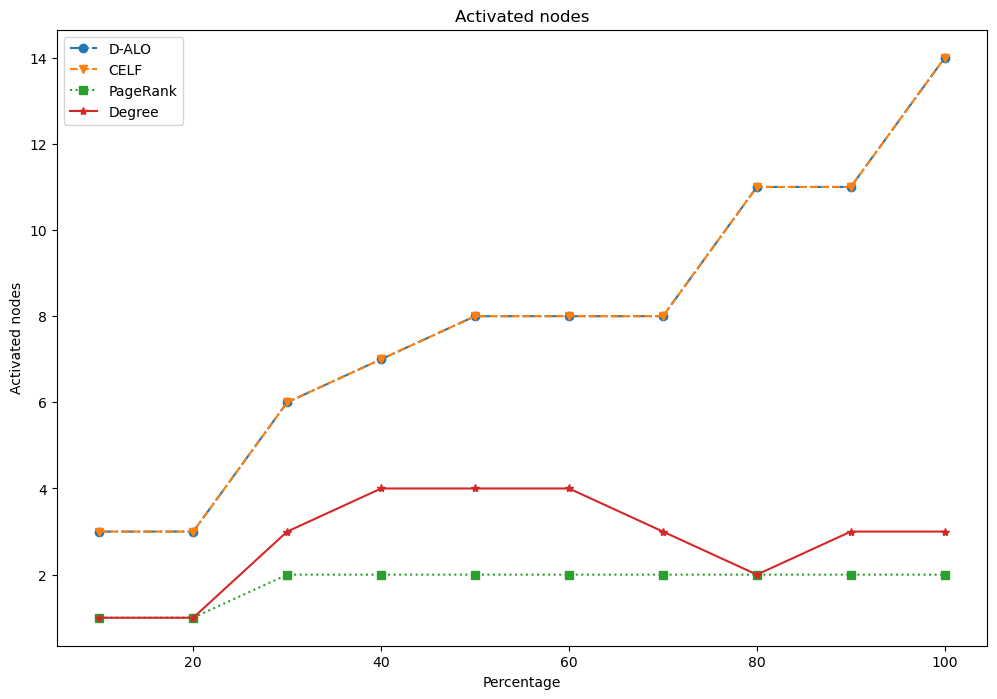

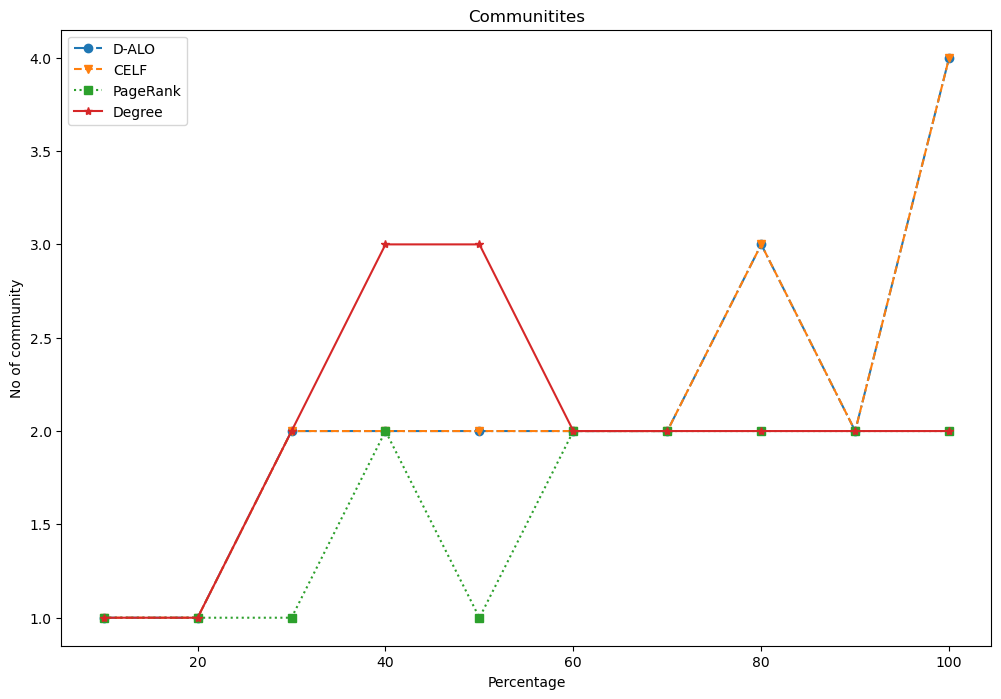

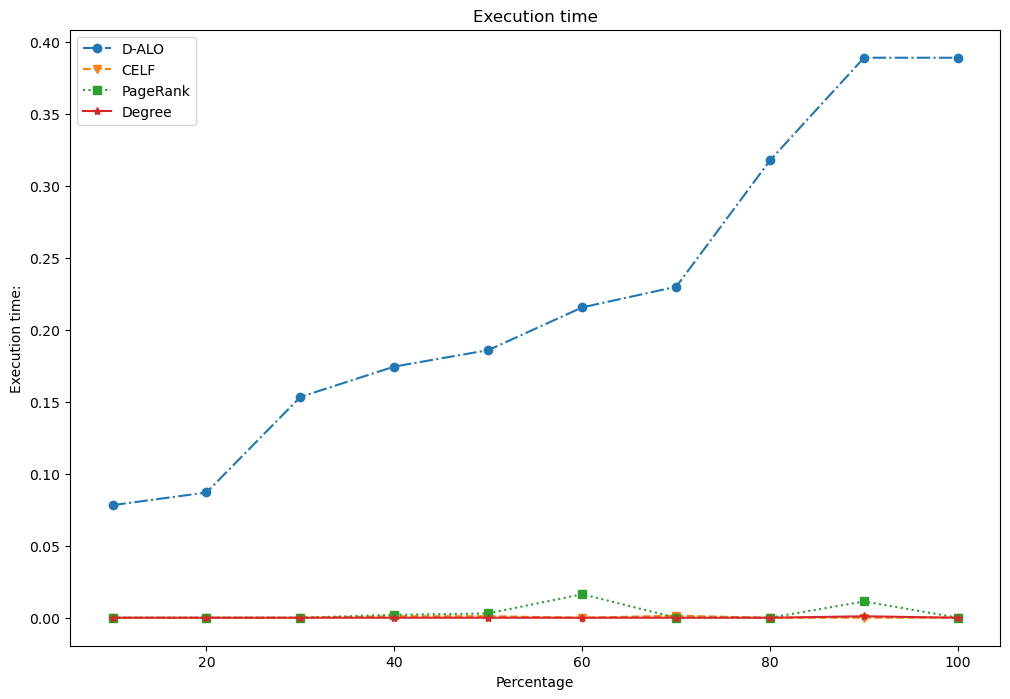

(4, 31)


In [42]:
iteration=1
Result_file_name="EW_As_003.xlsx"
comm_file_path=' '
result=executeDiv(iteration)
processResults(Result_file_name)